In [1]:
# from dask.distributed import Client, LocalCluster
# cluster = LocalCluster()
# client = Client(cluster)

In [2]:
from dask.distributed import Client,Scheduler
from dask_jobqueue import SLURMCluster
cluster = SLURMCluster(cores=1,processes=1,memory="47GB")
client = Client(cluster)
cluster.scale(cores=3)

/g/data/fu5/deg581/miniconda3/envs/devel3.9/lib/python3.9/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [3]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.0.128.165:45709,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [4]:
print(client)

<Client: 'tcp://10.0.128.165:45709' processes=0 threads=0, memory=0 B>


In [5]:
cd /g/data/fu5/deg581/OSSE_analysis/notebooks/

/g/data1a/fu5/deg581/OSSE_analysis/notebooks


In [6]:
### run my startup script
exec(open("../src/functions/fun_loadStartup.py").read())
### load my functions
exec(open("../src/functions/fun_loadMyFunctions.py").read())

%config InlineBackend.figure_format='png'

### Load grid
grdFile = '../data/raw/EACouter_varres_grd_mergedBLbry_uhroms.nc'
grid = loadRomsGrid(grdFile)


loaded my modules
loaded my own functions
loading ROMS grid from ../data/raw/EACouter_varres_grd_mergedBLbry_uhroms.nc


In [7]:
### new loads
import numpy.matlib
from xgcm import Grid
import matplotlib.ticker as mticker


### Load functions

In [8]:
Grid

xgcm.grid.Grid

In [9]:
### Other local functions

def loadOSSE(hisFilePath,prefix,filestring='0*.nc',overlapDays=7):
    chunks = {'ocean_time':1}
    filelist = glob.glob(hisFilePath+prefix+filestring)

    def preprocessRemoveLastDay(ds):
        '''remove the last 7 timesteps from each file'''
        return ds.isel(ocean_time = slice(0,-overlapDays))

#     for files in filelist: 
#         print(files)
    outName = xr.open_mfdataset(filelist,chunks, preprocess=preprocessRemoveLastDay, data_vars='minimal', compat='override', coords='minimal', parallel=True, join='right') 
    print('loaded from '+filelist[0]+' to '+filelist[-1])
    return outName

### function to load overlapping OSSE data
def loadOverlappedNetcdf(hisFilePath,prefix,filestring='0*.nc',overlapDays=7):
    chunks = {'ocean_time':1}
    filelist = sorted(glob.glob(hisFilePath+prefix+filestring))

    def preprocessRemoveLastDay(ds):
        '''remove the last 7 timesteps from each file'''
        return ds.isel(ocean_time = slice(0,-overlapDays))

    outName = xr.open_mfdataset(filelist,chunks, preprocess=preprocessRemoveLastDay, data_vars='minimal', compat='override', coords='minimal', parallel=True, join='right') 
    print('loaded from '+filelist[0]+' to '+filelist[-1])
    return outName

def dropDuplicateTimes(inputData):
    _, index = np.unique(inputData['ocean_time'], return_index=True)
    out = inputData.isel(ocean_time=index)
    return out

def calc_rmseSpatial(input1,input2,etaRange,xiRange):
    err2 = (input1-input2)**2
    # err=err2**(1/2)
    mse = indexMeanMetric(err2,etaRange,xiRange) #mean square error MSE
    output = mse**(1/2)
    return mse,output

# define function for calculating spatial mean
def indexMeanMetric(input,etaRange,xiRange):
    ''' iRange and jRange are converted to slices, so they are the start/end values of the range '''
    output = input.isel(eta_rho=slice(etaRange[0],etaRange[1]), xi_rho=slice(xiRange[0],xiRange[1])).mean(dim='eta_rho', skipna=True).mean(dim='xi_rho', skipna=True)
    return output

def simple_TimeSeries(inputDataX, inputDataY, plt_kwargs={}, ax=None):
    #Plotting
    if ax is None:
        ax = plt.gca()   
    hOut = ax.plot(inputDataX, inputDataY, **plt_kwargs)
    ax.grid(color='black', alpha=0.2, linestyle='--')
    return(hOut)

def plot_spatialMapSubplot(toPlotData, ax=None, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
    #Plotting
    if ax is None:
        ax = plt.gca()
    # plt.subplot(projection=ccrs.PlateCarree())
#     ax = fig.add_subplot(gs[ax], projection=ccrs.PlateCarree())
    ax.set_extent([147, 162.5, -42, -25])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',ax=ax, add_colorbar=False, **pcol_kwargs)       
    toPlotData.plot.contour('lon_rho','lat_rho',ax=ax, **cont_kwargs)
    gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
        #gl.xformatter = LONGITUDE_FORMATTER
        #gl.yformatter = LATITUDE_FORMATTER
    gl.right_labels = False
    gl.top_labels = False
    cax = inset_axes(ax,
                 width="5%",  # width = 10% of parent_bbox width
                 height="50%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.07,.39, 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )
    fig.colorbar(im, cax=cax)

def plot_spatialMapGSSubplot(toPlotData, ax=None, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
    #Plotting
    if ax is None:
        ax = plt.gca()
    # plt.subplot(projection=ccrs.PlateCarree())
#     ax = fig.add_subplot(gs[ax], projection=ccrs.PlateCarree())
    ax.set_extent([147, 162.5, -42, -25])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',ax=ax, add_colorbar=False, **pcol_kwargs)       
    toPlotData.plot.contour('lon_rho','lat_rho',ax=ax, **cont_kwargs)
    gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
        #gl.xformatter = LONGITUDE_FORMATTER
        #gl.yformatter = LATITUDE_FORMATTER
    gl.right_labels = False
    gl.top_labels = False
    cax = inset_axes(ax,
                 width="5%",  # width = 10% of parent_bbox width
                 height="50%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.07,.39, 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )
    fig.colorbar(im, cax=cax)

def calc_boxSpatial(grid,etaRange,xiRange):
    pt00lo = grid['lon_rho'].isel(eta_rho=etaRange[0],xi_rho=xiRange[0]).values
    pt01lo = grid['lon_rho'].isel(eta_rho=etaRange[0],xi_rho=xiRange[1]).values
    pt10lo = grid['lon_rho'].isel(eta_rho=etaRange[1],xi_rho=xiRange[0]).values
    pt11lo = grid['lon_rho'].isel(eta_rho=etaRange[1],xi_rho=xiRange[1]).values
    pt00la = grid['lat_rho'].isel(eta_rho=etaRange[0],xi_rho=xiRange[0]).values
    pt01la = grid['lat_rho'].isel(eta_rho=etaRange[0],xi_rho=xiRange[1]).values
    pt10la = grid['lat_rho'].isel(eta_rho=etaRange[1],xi_rho=xiRange[0]).values
    pt11la = grid['lat_rho'].isel(eta_rho=etaRange[1],xi_rho=xiRange[1]).values
    boxLo = np.array([pt00lo, pt01lo, pt11lo, pt10lo, pt00lo])
    boxLa = np.array([pt00la, pt01la, pt11la, pt10la, pt00la])
    return boxLo,boxLa

def datestring_to_serial_day(datestring,epochY=1990,epochm=1,epochd=1,epochH=0,epochM=0):
    import pandas as pd
    import datetime
    serial_day_timedelta = pd.to_datetime(datestring) - datetime.datetime(epochY,epochm,epochd,epochH,epochM)
    corrected_serial_day_number = serial_day_timedelta.days + serial_day_timedelta.seconds/86400
    return corrected_serial_day_number


def serial_day_to_datestring(day,epochY=1990,epochm=1,epochd=1,epochH=0,epochM=0):
    import datetime
    corrected_date = datetime.datetime(epochY,epochm,epochd,epochH,epochM) + datetime.timedelta(day)
    return corrected_date.strftime("%Y-%m-%d %H:%M")


def spatialMap_addGSSubplot(toPlotData, gs, nrow,ncol, labelText, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
    ax = fig.add_subplot(gs[nrow,ncol], projection=ccrs.PlateCarree())
    ax.set_extent([148, 161, -42, -25])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',ax=ax, add_colorbar=False, **pcol_kwargs)       
    gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
    gl.right_labels = False
    gl.top_labels = False
    gl.xlocator = mticker.FixedLocator(np.arange(150,160))
    gl.ylocator = mticker.FixedLocator(np.arange(-45,45))

    cax = inset_axes(ax,
                 width="5%",  # width = 10% of parent_bbox width
                 height="50%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.07,.39, 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )
    fig.colorbar(im, cax=cax)
    ax.text(0.01, 0.99, labelText, transform=ax.transAxes,fontsize=12, fontweight='bold', va='top')
    ax.set_title('')
    return ax

In [10]:
### Functions for calculating metrics

def loadOSSEdata(hisOSSEFilePath,prefixForecast,prefixAnalysis,dates):
    filenameForecast=hisOSSEFilePath+prefixForecast+'0'+str(dates)+'.nc'
    filenameAnalysis=hisOSSEFilePath+prefixAnalysis+'0'+str(dates)+'.nc'
    sshForecast=xr.open_dataset(filenameForecast).zeta.load()
    sshAnalysis=xr.open_dataset(filenameAnalysis).zeta.load()
    sstForecast=xr.open_dataset(filenameForecast).temp.isel(s_rho=-1).load()
    sstAnalysis=xr.open_dataset(filenameAnalysis).temp.isel(s_rho=-1).load()
    return sshForecast, sshAnalysis, sstForecast, sstAnalysis

def loadTruthdata(hisTruthFilePath,prefixTruth,dates):
    filenameTruth   =hisTruthFilePath+prefixTruth+'0'+str(dates)+'.nc'
    sshTruth   =xr.open_dataset(filenameTruth).zeta.load()
    sstTruth=xr.open_dataset(filenameTruth).temp.isel(s_rho=-1).load()
    return sshTruth, sstTruth

def compileOSSETimeMetricSSH(hisOSSEFilePath,prefixForecast,prefixAnalysis,etaRangeMetric,xiRangeMetric,datelist):
    for dates in datelist:
        sshForecast,sshAnalysis,sstForecast,sstAnalysis = loadOSSEdata(hisOSSEFilePath,prefixForecast,prefixAnalysis,dates)       
        if dates == datelist[0]:
            ssh_metricForecast = indexMeanMetric(sshForecast, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            ssh_metricAnalysis = indexMeanMetric(sshAnalysis, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        elif dates != datelist[0]:
            temp = indexMeanMetric(sshForecast, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            ssh_metricForecast = xr.merge([ssh_metricForecast, temp])
            temp = indexMeanMetric(sshAnalysis, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            ssh_metricAnalysis = xr.merge([ssh_metricAnalysis, temp])
    return ssh_metricForecast,ssh_metricAnalysis

def compileOSSETimeMetricSST(hisOSSEFilePath,prefixForecast,prefixAnalysis,etaRangeMetric,xiRangeMetric,datelist):
    for dates in datelist:
        sshForecast,sshAnalysis,sstForecast,sstAnalysis = loadOSSEdata(hisOSSEFilePath,prefixForecast,prefixAnalysis,dates)       
        if dates == datelist[0]:
            sst_metricForecast = indexMeanMetric(sstForecast, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            sst_metricAnalysis = indexMeanMetric(sstAnalysis, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        elif dates != datelist[0]:
            temp = indexMeanMetric(sstForecast, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            sst_metricForecast = xr.merge([sst_metricForecast, temp])
            temp = indexMeanMetric(sstAnalysis, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            sst_metricAnalysis = xr.merge([sst_metricAnalysis, temp])
    return sst_metricForecast,sst_metricAnalysis

def compileTruthTimeMetric(hisTruthFilePath,prefixTruth,etaRangeMetric,xiRangeMetric,datelist):
    for dates in datelist:
        sshTruth,sstTruth = loadTruthdata(hisTruthFilePath,prefixTruth,dates)
        if dates == datelist[0]:
            ssh_metricTruth = indexMeanMetric(sshTruth, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            sst_metricTruth = indexMeanMetric(sstTruth, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        elif dates != datelist[0]:
            temp = indexMeanMetric(sshTruth, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            ssh_metricTruth = xr.merge([ssh_metricTruth, temp])
            temp = indexMeanMetric(sstTruth, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            sst_metricTruth = xr.merge([sst_metricTruth, temp])
    return ssh_metricTruth, sst_metricTruth

In [11]:
### Functions for loading and processing ROMS data nicely... ROMS FUNCTIONS

from xgcm import Grid

def makeROMSGridObject(ds,rename=True):
    if rename==True:
        ds = ds.rename({'eta_u': 'eta_rho', 'xi_v': 'xi_rho', 'xi_psi': 'xi_u', 'eta_psi': 'eta_v'})

    coords={'X':{'center':'xi_rho', 'inner':'xi_u'}, 
        'Y':{'center':'eta_rho', 'inner':'eta_v'}, 
        'Z':{'center':'s_rho', 'outer':'s_w'}}

    grid = Grid(ds, coords=coords, periodic=[])

    if ds.Vtransform == 1:
        Zo_rho = ds.hc * (ds.s_rho - ds.Cs_r) + ds.Cs_r * ds.h
        z_rho = Zo_rho + ds.zeta * (1 + Zo_rho/ds.h)
        Zo_w = ds.hc * (ds.s_w - ds.Cs_w) + ds.Cs_w * ds.h
        z_w = Zo_w + ds.zeta * (1 + Zo_w/ds.h)
    elif ds.Vtransform == 2:
        Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
        z_rho = ds.zeta + (ds.zeta + ds.h) * Zo_rho
        Zo_w = (ds.hc * ds.s_w + ds.Cs_w * ds.h) / (ds.hc + ds.h)
        z_w = Zo_w * (ds.zeta + ds.h) + ds.zeta

    ds.coords['z_w'] = z_w.where(ds.mask_rho, 0).transpose('ocean_time', 's_w', 'eta_rho', 'xi_rho')
    ds.coords['z_rho'] = z_rho.where(ds.mask_rho, 0).transpose('ocean_time', 's_rho', 'eta_rho', 'xi_rho')
    # Other Option is to transpose arrays and fill NaNs with a minimal depth
    # ds['z_rho'] = z_rho.transpose(*('time', 's_rho','yh','xh'),transpose_coords=False).fillna(hmin)
    # ds['z_w'] = z_w.transpose(*('time', 's_w','yh','xh'),transpose_coords=False).fillna(hmin)
    ds.coords['z_rho0'] = z_rho.mean(dim='ocean_time')

     # interpolate depth of levels at U and V points
    ds['z_u'] = grid.interp(ds['z_rho'], 'X', boundary='fill')
    ds['z_v'] = grid.interp(ds['z_rho'], 'Y', boundary='fill')

    ds['pm_v'] = grid.interp(ds.pm, 'Y')
    ds['pn_u'] = grid.interp(ds.pn, 'X')
    ds['pm_u'] = grid.interp(ds.pm, 'X')
    ds['pn_v'] = grid.interp(ds.pn, 'Y')
    ds['pm_psi'] = grid.interp(grid.interp(ds.pm, 'Y'),  'X') # at psi points (eta_v, xi_u) 
    ds['pn_psi'] = grid.interp(grid.interp(ds.pn, 'X'),  'Y') # at psi points (eta_v, xi_u)

    ds['dx'] = 1/ds.pm
    ds['dx_u'] = 1/ds.pm_u
    ds['dx_v'] = 1/ds.pm_v
    ds['dx_psi'] = 1/ds.pm_psi

    ds['dy'] = 1/ds.pn
    ds['dy_u'] = 1/ds.pn_u
    ds['dy_v'] = 1/ds.pn_v
    ds['dy_psi'] = 1/ds.pn_psi

    ds['dz'] = grid.diff(ds.z_w, 'Z', boundary='fill')
    ds['dz_w'] = grid.diff(ds.z_rho, 'Z', boundary='fill')
    ds['dz_u'] = grid.interp(ds.dz, 'X')
    ds['dz_w_u'] = grid.interp(ds.dz_w, 'X')
    ds['dz_v'] = grid.interp(ds.dz, 'Y')
    ds['dz_w_v'] = grid.interp(ds.dz_w, 'Y')

    ds['dA'] = ds.dx * ds.dy

    metrics = {
        ('X',): ['dx', 'dx_u', 'dx_v', 'dx_psi'], # X distances
        ('Y',): ['dy', 'dy_u', 'dy_v', 'dy_psi'], # Y distances
        ('Z',): ['dz', 'dz_u', 'dz_v', 'dz_w', 'dz_w_u', 'dz_w_v'], # Z distances
        ('X', 'Y'): ['dA'] # Areas
    }
    grid = Grid(ds, coords=coords, metrics=metrics, periodic=[])

    return ds, grid

def makeROMSGridObject(gridIn):
    gridOut = Grid(gridIn, 
    coords={'X':{'center':'xi_rho', 'inner':'xi_u'}, 
    'Y':{'center':'eta_rho', 'inner':'eta_v'}, 
    'Z':{'center':'s_rho', 'outer':'s_w'}},
    # metrics={
    #     ('X',): ['dx', 'dx_u', 'dx_v', 'dx_psi'], # X distances
    #     ('Y',): ['dy', 'dy_u', 'dy_v', 'dy_psi'], # Y distances
    #     ('Z',): ['dz', 'dz_u', 'dz_v', 'dz_w', 'dz_w_u', 'dz_w_v'], # Z distances
    #     ('X', 'Y'): ['dA'] # Areas
    # },
    periodic=False)
    return gridOut

def horizontalSectionROMS(grid,inputVal,targetDepth):
    # v2
    output = grid.transform(inputVal, 'Z', targetDepth,
                                    target_data=inputVal['z_rho'],
                                    method='linear').squeeze()
    return output

In [12]:

def loadOSSEFileList(hisFilePath,prefix,filelist,overlapDays=7):
    chunks = {'ocean_time':1}
    def preprocessRemoveLastDay(ds):
        '''remove the last 7 timesteps from each file'''
        return ds.isel(ocean_time = slice(0,-overlapDays))

    outName = xr.open_mfdataset(filelist,chunks, preprocess=preprocessRemoveLastDay, data_vars='minimal', compat='override', coords='minimal', parallel=True, join='right') 
    print('loaded from '+filelist[0]+' to '+filelist[-1])
    return outName

def loadOverlappedNetcdfFileList(hisFilePath,prefix,filelist,overlapDays=7):
    chunks = {'ocean_time':1}
    def preprocessRemoveLastDay(ds):
        '''remove the last 7 timesteps from each file'''
        return ds.isel(ocean_time = slice(0,-overlapDays))

    outName = xr.open_mfdataset(filelist,chunks, preprocess=preprocessRemoveLastDay, data_vars='minimal', compat='override', coords='minimal', parallel=True, join='right') 
    print('loaded from '+filelist[0]+' to '+filelist[-1])
    return outName

def loadNetcdfFileListAverages(hisFilePath,prefix,filelist):

    outName = xr.open_mfdataset(filelist, data_vars='minimal', compat='override', coords='minimal', parallel=True, join='right') 
    print('loaded from '+filelist[0]+' to '+filelist[-1])
    return outName

def generateFileList(hisFilePath,prefix,datelist):
    filelist=[hisFilePath+prefix+'0'+str(datelist[0])+'.nc']
    for dates in datelist[1:]:
        filenameToAppend=hisFilePath+prefix+'0'+str(dates)+'.nc'
        filelist.append(filenameToAppend)

#         print(filelist)
    return filelist

# downsample data to daily.
def calc_dailyDownsample(ds):
    ds_withtime = ds.drop([ var for var in ds.variables if not 'ocean_time' in ds[var].dims ])
    ds_timeless = ds.drop([ var for var in ds.variables if     'ocean_time' in ds[var].dims ])
    ds_workaround = xr.merge([ds_timeless, ds_withtime.resample(ocean_time='5D').mean('ocean_time')])
    return ds_workaround

# calculate EKE metrics
def calc_timeMeanEKE(input):
    u_eastward_top = input.u_eastward.isel(s_rho=-1)
    v_northward_top = input.v_northward.isel(s_rho=-1)

    u_bar = u_eastward_top.mean("ocean_time")
    v_bar = v_northward_top.mean("ocean_time")

    mke = 0.5*(u_bar**2 + v_bar**2)

    u_prime = u_eastward_top - u_bar
    v_prime = v_northward_top - v_bar

    eke = 0.5*(u_prime**2 + v_prime**2)

    eketimemean = (eke*input.dA).sum(dim=['eta_rho','xi_rho'],skipna=True)/(input.dA).sum(dim=['eta_rho','xi_rho'],skipna=True)
    return eketimemean

def calc_MKEandEKElevel(input,level):
    u_eastward = input.u_eastward
    v_northward = input.v_northward

    u_bar = u_eastward.isel(s_rho=level).mean("ocean_time")
    v_bar = v_northward.isel(s_rho=level).mean("ocean_time")

    mke = 0.5*(u_bar**2 + v_bar**2)

    u_prime = u_eastward.isel(s_rho=level) - u_bar
    v_prime = v_northward.isel(s_rho=level) - v_bar

    eke = 0.5*(u_prime**2 + v_prime**2)
    
    input['mke']=mke
    input['eke']=eke
    return input

def calc_MKEandEKEall(input):
    u_eastward = input.u_eastward
    v_northward = input.v_northward

    u_bar = u_eastward.mean("ocean_time")
    v_bar = v_northward.mean("ocean_time")

    mke = 0.5*(u_bar**2 + v_bar**2)

    u_prime = u_eastward - u_bar
    v_prime = v_northward - v_bar

    eke = 0.5*(u_prime**2 + v_prime**2)
    
    input['mke']=mke
    input['eke']=eke
    return input

def horizontalSectionROMS(grid,inputVal,targetDepth):
    # v2
    output = grid.transform(inputVal, 'Z', targetDepth,
                                    target_data=inputVal['z_rho0'],
                                    method='linear').squeeze()
    return output

def calc_areaAverageROMS(input,grid):
    output = (input*grid.dA).sum(dim=['eta_rho','xi_rho'],skipna=True)/(grid.dA).sum(dim=['eta_rho','xi_rho'],skipna=True)
    return output

def calc_areaMedianROMS(input,grid):
    output = input*(grid.dA/grid.dA.sum(dim=['eta_rho','xi_rho'],skipna=True))
    output = np.median(output.values.flatten())
    return output

def process_trimVarsROMS(input,varsKeep):
    output_backup = input
    output = input[varsKeep]
    return output,output_backup

def calc_volTrans(input,etaLocation,velCutoff,depthCutoff,lonCutoff):
    input_nw = input.v_northward
    input_masked = input_nw.where(input_nw<=velCutoff).where(input.z_rho>depthCutoff).where(input_nw.lon_rho<lonCutoff)
    output = (input_masked.isel(eta_rho=transectEta)*input.dz.isel(eta_rho=transectEta)*input.dx.isel(eta_rho=transectEta)).sum(dim='s_rho').sum(dim='xi_rho')
    return output

def calc_volTransSlice(input,velCutoff,depthCutoff,lonCutoff):
    input_nw = input.v_northward
    input_masked = input_nw.where(input_nw<=velCutoff).where(input.z_rho>depthCutoff).where(input_nw.lon_rho<lonCutoff)
    output = (input_masked*input.dz*input.dx).sum(dim='s_rho').sum(dim='xi_rho')
    return output

def calc_volTransSliceNorth(input,velCutoff,depthCutoff,lonCutoff):
    input_nw = input.v_northward
    input_masked = input_nw.where(input_nw>=velCutoff).where(input.z_rho>depthCutoff).where(input_nw.lon_rho<lonCutoff)
    output = (input_masked*input.dz*input.dx).sum(dim='s_rho').sum(dim='xi_rho')
    return output

def calc_depthAverageROMS(input,grid,etaTransect):
    dz = grid.dz.mean(dim='ocean_time').isel(eta_rho=etaTransect)
    dx = grid.dx.isel(eta_rho=etaTransect)
    output = ((input*dz*dx).sum(dim=['xi_rho','s_rho'],skipna=True))/(dz*dx).sum(dim=['xi_rho','s_rho'],skipna=True)
    return output

def calc_depthAverageROMS2(input,dx,dz0,etaTransect):
    input = input.isel(eta_rho=etaTransect)
    dz = dz0.isel(eta_rho=etaTransect)
    dx = dx.isel(eta_rho=etaTransect)
    output = ((input*dz*dx).sum(dim=['xi_rho','s_rho'],skipna=True))/(dz*dx).sum(dim=['xi_rho','s_rho'],skipna=True)
    return output

In [13]:
hisTruthFilePath='/g/data/fu5/deg581/EAC_2yr_truthRun_obsVerification/output/' # Truth file settings

hisOSSEFilePath1='/g/data/fu5/eac/OSSEs/OSSE_ssh_sst_is4dvar/output/'
modOSSEFilePath1='/g/data/fu5/eac/OSSEs/OSSE_ssh_sst_is4dvar/output/'
obsOSSEFilePath1='/g/data/fu5/eac/OSSEs/OSSE_ssh_sst_is4dvar/output/'

hisOSSEFilePath2='/g/data/fu5/deg581/OSSE_SSHSST_XBT/output/'
modOSSEFilePath2='/g/data/fu5/deg581/OSSE_SSHSST_XBT/output/'
obsOSSEFilePath2='/g/data/fu5/deg581/OSSE_SSHSST_XBT/output/'

hisOSSEFilePath3='/g/data/fu5/deg581/OSSE_SSHSST_XBT_NORTH/output/'
modOSSEFilePath3='/g/data/fu5/deg581/OSSE_SSHSST_XBT_NORTH/output/'
obsOSSEFilePath3='/g/data/fu5/deg581/OSSE_SSHSST_XBT_NORTH/output/'

hisOSSEFilePath4='/g/data/fu5/deg581/OSSE_SSHSST_XBT_SOUTH/output/'
modOSSEFilePath4='/g/data/fu5/deg581/OSSE_SSHSST_XBT_SOUTH/output/'
obsOSSEFilePath4='/g/data/fu5/deg581/OSSE_SSHSST_XBT_SOUTH/output/'

prefixForecast='roms_fwd_outer0_'
prefixAnalysis='roms_fwd_outer1_'
prefixAverage='roms_avg_outer1_'
prefixTruth='outer_his_'
prefixTruthAverage='outer_avg_'

prefixObs='obs_0'
prefixMod='eac_mod_'
prefixPert='outer_his_'

outFigurePath='../cache/out/'

In [14]:
timeRange = [8005, 8401]
datelist = np.array(range(timeRange[0],timeRange[1],4))

# time_range_to_load_S = slice('2012-01-01','2012-06-01')
# time_range_to_load_N = slice('2012-06-01','2012-11-01')

time_range_to_load_S = slice('2012-04-20','2012-04-21')
time_range_to_load_N = slice('2012-03-06','2012-03-07')
time_range_to_load_eddyN = slice('2012-06-29','2012-07-09')
time_range_to_load_eddy1 = slice('2012-03-06','2012-03-12')
time_range_to_load_eddy2 = slice('2012-07-29','2012-08-08')
time_range_to_load_eddy3 = slice('2012-03-11','2012-03-16')


range_S = (str(time_range_to_load_S.start)+' - '+str(time_range_to_load_S.stop))
range_N = (str(time_range_to_load_N.start)+' - '+str(time_range_to_load_N.stop))
range_eddyN = (str(time_range_to_load_eddyN.start)+' - '+str(time_range_to_load_eddyN.stop))
range_eddy1 = (str(time_range_to_load_eddy1.start)+' - '+str(time_range_to_load_eddy1.stop))
range_eddy2 = (str(time_range_to_load_eddy2.start)+' - '+str(time_range_to_load_eddy2.stop))
range_eddy3 = (str(time_range_to_load_eddy3.start)+' - '+str(time_range_to_load_eddy3.stop))

In [15]:
# Load zeta data
VarToKeep = ['z_rho0','temp','dz_w']#,'dA','dx','dy','dz']

outputPath = '/g/data/fu5/deg581/OSSE_analysis/data/proc/'
outputPrefix = 'output_'
expNames=['truth','OSSE_SSHSST','OSSE_SSHSST_XBT','OSSE_SSHSST_XBT_N','OSSE_SSHSST_XBT_S']
outputSuffix = '_'+str(timeRange[0])+'_'+str(timeRange[1])+'.nc'
filelistTruth = outputPath+outputPrefix+expNames[0]+outputSuffix
filelist_SSHSST=outputPath+outputPrefix+expNames[1]+outputSuffix
filelist_SSHSST_XBT=outputPath+outputPrefix+expNames[2]+outputSuffix
filelist_SSHSST_XBT_N=outputPath+outputPrefix+expNames[3]+outputSuffix
filelist_SSHSST_XBT_S=outputPath+outputPrefix+expNames[4]+outputSuffix
print('load truth')
truth = xr.open_dataset(filelistTruth)

truth = truth.sel(ocean_time=slice('2012-01-01','2012-12-31'))


truth,truth_bu = process_trimVarsROMS(truth,VarToKeep)
truth = truth.drop_vars('z_rho')
truth["dz0"] = truth_bu.dz.mean(dim='ocean_time')
truth["dz_w0"]=truth_bu.dz_w.mean(dim='ocean_time')
truth["dx"] = truth_bu.dx
truth["z_rho0"] = truth.z_rho0.fillna(0)
truth["z_w0"]=truth_bu.z_w.mean(dim='ocean_time').fillna(0)
truth["s_w"] = truth_bu.s_w
truth["s_w3"],dump = xr.broadcast(truth.s_w,truth.lon_rho)

print('load OSSEs')

OSSE_SSHSST= xr.open_dataset(filelist_SSHSST)
OSSE_SSHSST_XBT= xr.open_dataset(filelist_SSHSST_XBT)
OSSE_SSHSST_XBT_N= xr.open_dataset(filelist_SSHSST_XBT_N)
OSSE_SSHSST_XBT_S= xr.open_dataset(filelist_SSHSST_XBT_S)

OSSE_SSHSST = OSSE_SSHSST.sel(ocean_time=slice('2012-01-01','2012-12-31'))
OSSE_SSHSST_XBT = OSSE_SSHSST_XBT.sel(ocean_time=slice('2012-01-01','2012-12-31'))
OSSE_SSHSST_XBT_N = OSSE_SSHSST_XBT_N.sel(ocean_time=slice('2012-01-01','2012-12-31'))
OSSE_SSHSST_XBT_S = OSSE_SSHSST_XBT_S.sel(ocean_time=slice('2012-01-01','2012-12-31'))



print('make grid file')

#load grid file
grid = makeROMSGridObject(OSSE_SSHSST)

print('trim vars')
OSSE_SSHSST,OSSE_SSHSST_bu = process_trimVarsROMS(OSSE_SSHSST,VarToKeep)
OSSE_SSHSST_XBT_S,OSSE_SSHSST_XBT_S_bu = process_trimVarsROMS(OSSE_SSHSST_XBT_S,VarToKeep)
OSSE_SSHSST_XBT_N,OSSE_SSHSST_XBT_N_bu = process_trimVarsROMS(OSSE_SSHSST_XBT_N,VarToKeep)
OSSE_SSHSST_XBT,OSSE_SSHSST_XBT_bu = process_trimVarsROMS(OSSE_SSHSST_XBT,VarToKeep)

print('make dz vars 1')

OSSE_SSHSST = OSSE_SSHSST.drop_vars('z_rho')
OSSE_SSHSST_XBT = OSSE_SSHSST_XBT.drop_vars('z_rho')
OSSE_SSHSST_XBT_N = OSSE_SSHSST_XBT_N.drop_vars('z_rho')
OSSE_SSHSST_XBT_S = OSSE_SSHSST_XBT_S.drop_vars('z_rho')
print('make dz vars 2')

OSSE_SSHSST["z_rho0"] = OSSE_SSHSST.z_rho0.fillna(0)
OSSE_SSHSST_XBT["z_rho0"] = OSSE_SSHSST_XBT.z_rho0.fillna(0)
OSSE_SSHSST_XBT_N["z_rho0"] = OSSE_SSHSST_XBT_N.z_rho0.fillna(0)
OSSE_SSHSST_XBT_S["z_rho0"] = OSSE_SSHSST_XBT_S.z_rho0.fillna(0)
print('make dz vars 3')

OSSE_SSHSST["z_w0"]=OSSE_SSHSST_bu.z_w.mean(dim='ocean_time').fillna(0)
OSSE_SSHSST_XBT["z_w0"]=OSSE_SSHSST_XBT_bu.z_w.mean(dim='ocean_time').fillna(0)
OSSE_SSHSST_XBT_N["z_w0"]=OSSE_SSHSST_XBT_N_bu.z_w.mean(dim='ocean_time').fillna(0)
OSSE_SSHSST_XBT_S["z_w0"]=OSSE_SSHSST_XBT_S_bu.z_w.mean(dim='ocean_time').fillna(0)

# print('make dz vars 4')
# OSSE_SSHSST["dz0"] = OSSE_SSHSST_bu.dz.mean(dim='ocean_time')
# OSSE_SSHSST_XBT["dz0"] = OSSE_SSHSST_XBT_bu.dz.mean(dim='ocean_time')
# OSSE_SSHSST_XBT_N["dz0"] = OSSE_SSHSST_XBT_N_bu.dz.mean(dim='ocean_time')
# OSSE_SSHSST_XBT_S["dz0"] = OSSE_SSHSST_XBT_S_bu.dz.mean(dim='ocean_time')

print('make dz vars 5')
OSSE_SSHSST["dz_w0"]=OSSE_SSHSST.dz_w.mean(dim='ocean_time')
OSSE_SSHSST_XBT["dz_w0"]=OSSE_SSHSST_XBT.dz_w.mean(dim='ocean_time')
OSSE_SSHSST_XBT_N["dz_w0"]=OSSE_SSHSST_XBT_N_bu.dz_w.mean(dim='ocean_time')
OSSE_SSHSST_XBT_S["dz_w0"]=OSSE_SSHSST_XBT_S_bu.dz_w.mean(dim='ocean_time')

print('make dx vars')
OSSE_SSHSST["dx"] = OSSE_SSHSST_bu.dx
OSSE_SSHSST_XBT["dx"] = OSSE_SSHSST_XBT_bu.dx
OSSE_SSHSST_XBT_N["dx"] = OSSE_SSHSST_XBT_N_bu.dx
OSSE_SSHSST_XBT_S["dx"] = OSSE_SSHSST_XBT_S_bu.dx

print('make s_w vars')

OSSE_SSHSST["s_w"] = OSSE_SSHSST_bu.s_w
OSSE_SSHSST["s_w3"],dump = xr.broadcast(OSSE_SSHSST.s_w,OSSE_SSHSST.lon_rho)
OSSE_SSHSST_XBT["s_w"] = OSSE_SSHSST_XBT_bu.s_w
OSSE_SSHSST_XBT["s_w3"],dump = xr.broadcast(OSSE_SSHSST_XBT.s_w,OSSE_SSHSST_XBT.lon_rho)
OSSE_SSHSST_XBT_N["s_w"] = OSSE_SSHSST_XBT_N_bu.s_w
OSSE_SSHSST_XBT_N["s_w3"],dump = xr.broadcast(OSSE_SSHSST_XBT_N.s_w,OSSE_SSHSST_XBT_N.lon_rho)
OSSE_SSHSST_XBT_S["s_w"] = OSSE_SSHSST_XBT_S_bu.s_w
OSSE_SSHSST_XBT_S["s_w3"],dump = xr.broadcast(OSSE_SSHSST_XBT_S.s_w,OSSE_SSHSST_XBT_S.lon_rho)

print('drop extraneous vars')
truth = truth.drop_vars(['z_w','dz_w'])
OSSE_SSHSST = OSSE_SSHSST.drop_vars(['z_w','dz_w'])
OSSE_SSHSST_XBT = OSSE_SSHSST_XBT.drop_vars(['z_w','dz_w'])
OSSE_SSHSST_XBT_N = OSSE_SSHSST_XBT_N.drop_vars(['z_w','dz_w'])
OSSE_SSHSST_XBT_S = OSSE_SSHSST_XBT_S.drop_vars(['z_w','dz_w'])

SSHSST = OSSE_SSHSST
SSHSST_XBT_N = OSSE_SSHSST_XBT_N
SSHSST_XBT_S = OSSE_SSHSST_XBT_S
SSHSST_XBT = OSSE_SSHSST_XBT

print('load datasets')


truth.load(), print('done, loaded ~'+str(truth.nbytes/1024/1024/1024)+'G')
SSHSST.load(), print('done, loaded ~'+str(SSHSST.nbytes/1024/1024/1024)+'G')
SSHSST_XBT.load(), print('done, loaded ~'+str(SSHSST_XBT.nbytes/1024/1024/1024)+'G')
SSHSST_XBT_N.load(), print('done, loaded ~'+str(SSHSST_XBT_N.nbytes/1024/1024/1024)+'G')
SSHSST_XBT_S.load(), print('done, loaded ~'+str(SSHSST_XBT_S.nbytes/1024/1024/1024)+'G')


load truth
load OSSEs
make grid file
trim vars
make dz vars 1
make dz vars 2
make dz vars 3
make dz vars 5
make dx vars
make s_w vars
drop extraneous vars
load datasets
done, loaded ~1.5263882204890251G
done, loaded ~1.5071156546473503G
done, loaded ~1.5071156546473503G
done, loaded ~1.5071156546473503G
done, loaded ~1.5071156546473503G


(<xarray.Dataset>
 Dimensions:     (eta_rho: 317, xi_rho: 272, s_rho: 30, ocean_time: 74, s_w: 31)
 Coordinates:
     z_rho0      (eta_rho, xi_rho, s_rho) float64 0.0 0.0 0.0 ... -4.485 -1.037
   * s_rho       (s_rho) float64 -0.9715 -0.9156 -0.8614 ... -0.0156 -0.004799
   * s_w         (s_w) float64 -1.0 -0.9433 -0.8883 ... -0.02161 -0.01 0.0
     lon_rho     (eta_rho, xi_rho) float64 147.1 147.1 147.2 ... 162.2 162.2
     lat_rho     (eta_rho, xi_rho) float64 -38.5 -38.51 -38.52 ... -28.15 -28.16
   * ocean_time  (ocean_time) datetime64[ns] 2012-01-01 2012-01-06 ... 2012-12-31
 Dimensions without coordinates: eta_rho, xi_rho
 Data variables:
     temp        (ocean_time, s_rho, eta_rho, xi_rho) float64 nan nan ... 23.61
     z_w0        (s_w, eta_rho, xi_rho) float64 0.0 0.0 0.0 ... 0.4931 0.4931
     dz_w0       (s_w, eta_rho, xi_rho) float64 0.0 0.0 0.0 ... 1.029 1.029 1.029
     dx          (eta_rho, xi_rho) float64 2.996e+03 2.996e+03 ... 6e+03 6e+03
     s_w3        (s_w, eta_r

In [16]:

def makeROMSGridObject(gridIn):
    gridOut = Grid(gridIn, 
    coords={'X':{'center':'xi_rho', 'inner':'xi_u'}, 
    'Y':{'center':'eta_rho', 'inner':'eta_v'}, 
    'Z':{'center':'s_rho', 'outer':'s_w'}},
    metrics={
        ('X',): ['dx', 'dx_u', 'dx_v', 'dx_psi'], # X distances
        ('Y',): ['dy', 'dy_u', 'dy_v', 'dy_psi'], # Y distances
        ('Z',): ['dz', 'dz_u', 'dz_v', 'dz_w', 'dz_w_u', 'dz_w_v'], # Z distances
        ('X', 'Y'): ['dA'] # Areas
    },
    periodic=False)
    return gridOut


grid = makeROMSGridObject(OSSE_SSHSST_bu)

In [17]:
grid._metrics

{frozenset({'X'}): [<xarray.DataArray 'dx' (eta_rho: 317, xi_rho: 272)>
  array([[2995.682625, 2995.682625, 2986.681629, ..., 6000.786363, 6000.786877,
          6000.786877],
         [2995.682344, 2995.682344, 2986.68135 , ..., 6000.785187, 6000.7857  ,
          6000.7857  ],
         [2995.682063, 2995.682063, 2986.68107 , ..., 6000.784013, 6000.784526,
          6000.784526],
         ...,
         [2995.606454, 2995.606454, 2986.605879, ..., 6000.47382 , 6000.474194,
          6000.474194],
         [2995.606242, 2995.606242, 2986.605668, ..., 6000.472965, 6000.473338,
          6000.473338],
         [2995.606031, 2995.606031, 2986.605458, ..., 6000.472111, 6000.472484,
          6000.472484]])
  Dimensions without coordinates: eta_rho, xi_rho,
  <xarray.DataArray 'dx_u' (eta_rho: 317, xi_u: 271)>
  array([[2995.682625, 2991.175356, 2982.174341, ..., 6000.786106, 6000.78662 ,
          6000.786877],
         [2995.682344, 2991.175075, 2982.174062, ..., 6000.784931, 6000.785444,


In [18]:
# calculate the sharpest change in temp with depth (for each experiment)
## first calculate the grid coordinate where diff is maximised, then extract the z_w value where this occurs and only keep the top value
# import time
# tic = time.time()
# truth["z_dtdzmax"] = truth.z_w0.where(truth.s_w3==(grid.diff(truth.temp.mean(dim='ocean_time'),'Z',boundary='fill',fill_value=np.nan)/truth.dz_w0).idxmax(dim='s_w',skipna=True)).max(dim='s_w')
# elapsed = time.time() - tic
# print(elapsed)
# SSHSST["z_dtdzmax"] = SSHSST.z_w0.where(SSHSST.s_w3==(grid.diff(SSHSST.temp.mean(dim='ocean_time'),'Z',boundary='fill',fill_value=np.nan)/SSHSST.dz_w0).idxmax(dim='s_w',skipna=True)).max(dim='s_w')
# SSHSST_XBT["z_dtdzmax"] = SSHSST_XBT.z_w0.where(SSHSST_XBT.s_w3==(grid.diff(SSHSST_XBT.temp.mean(dim='ocean_time'),'Z',boundary='fill',fill_value=np.nan)/SSHSST_XBT.dz_w0).idxmax(dim='s_w',skipna=True)).max(dim='s_w')
# SSHSST_XBT_N["z_dtdzmax"] = SSHSST_XBT_N.z_w0.where(SSHSST_XBT_N.s_w3==(grid.diff(SSHSST_XBT_N.temp.mean(dim='ocean_time'),'Z',boundary='fill',fill_value=np.nan)/SSHSST_XBT_N.dz_w0).idxmax(dim='s_w',skipna=True)).max(dim='s_w')
# SSHSST_XBT_S["z_dtdzmax"] = SSHSST_XBT_S.z_w0.where(SSHSST_XBT_S.s_w3==(grid.diff(SSHSST_XBT_S.temp.mean(dim='ocean_time'),'Z',boundary='fill',fill_value=np.nan)/SSHSST_XBT_S.dz_w0).idxmax(dim='s_w',skipna=True)).max(dim='s_w')


In [19]:
# try now without the mean in time
# tic = time.time()
truth["z_dTdzmax"] = truth.z_w0.where(truth.s_w3==(grid.derivative(truth.temp,'Z',boundary='fill',fill_value=np.nan)).idxmax(dim='s_w',skipna=True)).max(dim='s_w')
# elapsed = time.time() - tic
# print(elapsed)
SSHSST["z_dTdzmax"] = SSHSST.z_w0.where(SSHSST.s_w3==(grid.derivative(SSHSST.temp,'Z',boundary='fill',fill_value=np.nan)).idxmax(dim='s_w',skipna=True)).max(dim='s_w')
SSHSST_XBT["z_dTdzmax"] = SSHSST_XBT.z_w0.where(SSHSST_XBT.s_w3==(grid.derivative(SSHSST_XBT.temp,'Z',boundary='fill',fill_value=np.nan)).idxmax(dim='s_w',skipna=True)).max(dim='s_w')
SSHSST_XBT_N["z_dTdzmax"] = SSHSST_XBT_N.z_w0.where(SSHSST_XBT_N.s_w3==(grid.derivative(SSHSST_XBT_N.temp,'Z',boundary='fill',fill_value=np.nan)).idxmax(dim='s_w',skipna=True)).max(dim='s_w')
SSHSST_XBT_S["z_dTdzmax"] = SSHSST_XBT_S.z_w0.where(SSHSST_XBT_S.s_w3==(grid.derivative(SSHSST_XBT_S.temp,'Z',boundary='fill',fill_value=np.nan)).idxmax(dim='s_w',skipna=True)).max(dim='s_w')
# SSHSST["z_dtdzmax"] = SSHSST.z_w0.where(SSHSST.s_w3==(grid.diff(SSHSST.temp.mean(dim='ocean_time'),'Z',boundary='fill',fill_value=np.nan)/SSHSST.dz_w0).idxmax(dim='s_w',skipna=True)).max(dim='s_w')
# SSHSST_XBT["z_dtdzmax"] = SSHSST_XBT.z_w0.where(SSHSST_XBT.s_w3==(grid.diff(SSHSST_XBT.temp.mean(dim='ocean_time'),'Z',boundary='fill',fill_value=np.nan)/SSHSST_XBT.dz_w0).idxmax(dim='s_w',skipna=True)).max(dim='s_w')
# SSHSST_XBT_N["z_dtdzmax"] = SSHSST_XBT_N.z_w0.where(SSHSST_XBT_N.s_w3==(grid.diff(SSHSST_XBT_N.temp.mean(dim='ocean_time'),'Z',boundary='fill',fill_value=np.nan)/SSHSST_XBT_N.dz_w0).idxmax(dim='s_w',skipna=True)).max(dim='s_w')
# SSHSST_XBT_S["z_dtdzmax"] = SSHSST_XBT_S.z_w0.where(SSHSST_XBT_S.s_w3==(grid.diff(SSHSST_XBT_S.temp.mean(dim='ocean_time'),'Z',boundary='fill',fill_value=np.nan)/SSHSST_XBT_S.dz_w0).idxmax(dim='s_w',skipna=True)).max(dim='s_w')



In [20]:
# truth.z_dtdzmax.plot(vmin=-170,vmax=0)
# plt.show()
# truth.z_dTdzmax.mean(dim='ocean_time').plot(vmin=-170,vmax=0)

AttributeError: 'Dataset' object has no attribute 'z_dtdzmax'

In [77]:
SSHSST["RMS_dTdzmax"] = (((SSHSST.z_dTdzmax - truth.z_dTdzmax)**2).mean(dim='ocean_time'))**0.5
SSHSST_XBT_N["RMS_dTdzmax"] = (((SSHSST_XBT_N.z_dTdzmax - truth.z_dTdzmax)**2).mean(dim='ocean_time'))**0.5
SSHSST_XBT_S["RMS_dTdzmax"] = (((SSHSST_XBT_S.z_dTdzmax - truth.z_dTdzmax)**2).mean(dim='ocean_time'))**0.5
SSHSST_XBT["RMS_dTdzmax"] = (((SSHSST_XBT.z_dTdzmax - truth.z_dTdzmax)**2).mean(dim='ocean_time'))**0.5

In [22]:
import cartopy.io.img_tiles as cimgt
stamen_terrain = cimgt.Stamen('terrain-background')

Text(0.5, 0.86, 'Thermocline depth (max dT/dz)')

<Figure size 432x288 with 0 Axes>

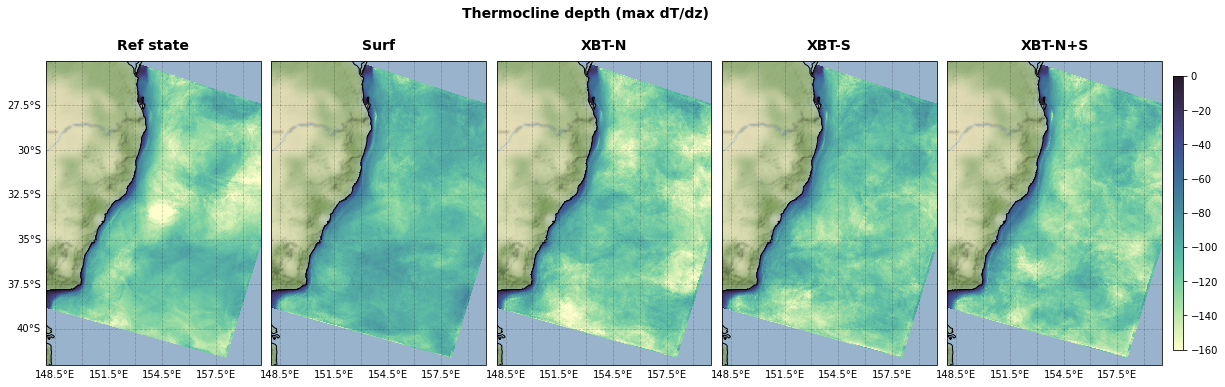

In [23]:


gs = gridspec.GridSpec(nrows=1,ncols=5,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[20,8])
ax = None

ax = fig.add_subplot(gs[0,0],projection=ccrs.PlateCarree())
ax.add_image(stamen_terrain, 4)
ax.add_feature(Coast, edgecolor='black')
truth.z_dTdzmax.mean(dim='ocean_time').plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap='cmo.deep',vmin=-160,vmax=0)
ax.set_extent([148, 160, -42, -25])
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
ax.text(0.5, 1.05, 'Ref state',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
# ax.text(0.05, 0.05, ('$\overline{x}$='+str(calc_areaAverageROMS(truth.z_dtdzmax,truth_bu).round(decimals=1).values)+'$\pm$'+str(truth.z_dtdzmax.std().round(decimals=1).values)+' m') ,fontsize=14, va='center', ha='left', transform=ax.transAxes)

ax = fig.add_subplot(gs[0,1],projection=ccrs.PlateCarree())
ax.add_image(stamen_terrain, 4)
ax.add_feature(Coast, edgecolor='black')
SSHSST.z_dTdzmax.mean(dim='ocean_time').plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap='cmo.deep',vmin=-160,vmax=0)
ax.set_extent([148, 160, -42, -25])
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
ax.text(0.5, 1.05, 'Surf',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
# ax.text(0.05, 0.05, ('$\overline{x}$='+str(calc_areaAverageROMS(SSHSST.z_dtdzmax,truth_bu).round(decimals=1).values)+'$\pm$'+str(SSHSST.z_dtdzmax.std().round(decimals=1).values)+' m') ,fontsize=14, va='center', ha='left', transform=ax.transAxes)

ax = fig.add_subplot(gs[0,2],projection=ccrs.PlateCarree())
ax.add_image(stamen_terrain, 4)
ax.add_feature(Coast, edgecolor='black')
SSHSST_XBT_N.z_dTdzmax.mean(dim='ocean_time').plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap='cmo.deep',vmin=-160,vmax=0)
ax.set_extent([148, 160, -42, -25])
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
ax.text(0.5, 1.05, 'XBT-N',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
# ax.text(0.05, 0.05, ('$\overline{x}$='+str(calc_areaAverageROMS(SSHSST_XBT_N.z_dtdzmax,truth_bu).round(decimals=1).values)+'$\pm$'+str(SSHSST_XBT_N.z_dtdzmax.std().round(decimals=1).values)+' m') ,fontsize=14, va='center', ha='left', transform=ax.transAxes)

ax = fig.add_subplot(gs[0,3],projection=ccrs.PlateCarree())
ax.add_image(stamen_terrain, 4)
ax.add_feature(Coast, edgecolor='black')
SSHSST_XBT_S.z_dTdzmax.mean(dim='ocean_time').plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap='cmo.deep',vmin=-160,vmax=0)
ax.set_extent([148, 160, -42, -25])
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
ax.text(0.5, 1.05, 'XBT-S',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
# ax.text(0.05, 0.05, ('$\overline{x}$='+str(calc_areaAverageROMS(SSHSST_XBT_S.z_dtdzmax,truth_bu).round(decimals=1).values)+'$\pm$'+str(SSHSST_XBT_S.z_dtdzmax.std().round(decimals=1).values)+' m') ,fontsize=14, va='center', ha='left', transform=ax.transAxes)

ax = fig.add_subplot(gs[0,4],projection=ccrs.PlateCarree())
ax.add_image(stamen_terrain, 4)
ax.add_feature(Coast, edgecolor='black')
im=SSHSST_XBT.z_dTdzmax.mean(dim='ocean_time').plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap='cmo.deep',vmin=-160,vmax=0)
ax.set_extent([148, 160, -42, -25])
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
ax.text(0.5, 1.05, 'XBT-N+S',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
# ax.text(0.05, 0.05, ('$\overline{x}$='+str(calc_areaAverageROMS(SSHSST_XBT.z_dtdzmax,truth_bu).round(decimals=1).values)+'$\pm$'+str(SSHSST_XBT.z_dtdzmax.std().round(decimals=1).values)+' m') ,fontsize=14, va='center', ha='left', transform=ax.transAxes)

cax = inset_axes(ax,
                width="5%",  # width = 10% of parent_bbox width
                height="90%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(1.05,.05, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax) 

fig.suptitle('Thermocline depth (max dT/dz)',y=.86, fontsize=14, fontweight='bold',)

AttributeError: 'Dataset' object has no attribute 'dTdz'

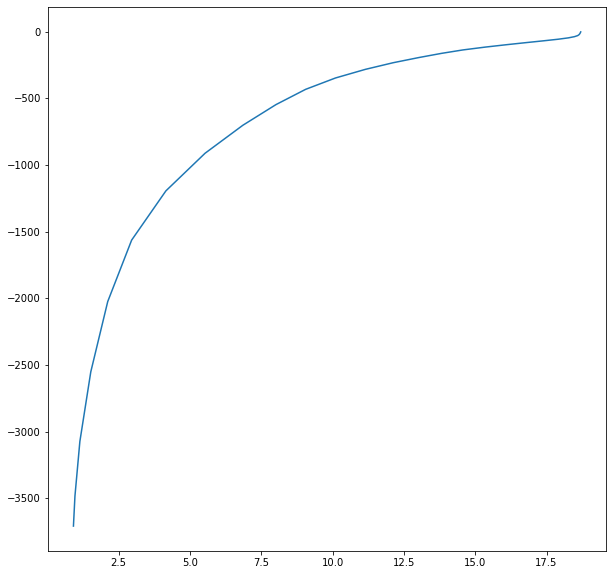

In [24]:
# plt.figure(figsize=[10,10])
# plt.plot(SSHSST.temp.mean(dim=['ocean_time']).isel(eta_rho=100,xi_rho=220),SSHSST.z_rho0.isel(eta_rho=100,xi_rho=220))
# # plt.plot([10,22],[SSHSST.dTdz.mean(dim=['ocean_time']).isel(eta_rho=125,xi_rho=140),SSHSST.dTdz.mean(dim=['ocean_time']).isel(eta_rho=125,xi_rho=140)])
# plt.plot(500*SSHSST.dTdz.mean(dim=['ocean_time']).isel(eta_rho=100,xi_rho=220),SSHSST.z_w0.isel(eta_rho=100,xi_rho=220))
# plt.ylim(-3000,0)

In [25]:
#parameters for calculation of MLD
temp_offsetMLD = 0.5 # 0.5 is Monteray and Levitus 1997; 0.8 is Kara et al., 2000,2003



In [26]:
# Interpolation method

from scipy import interpolate
def calc_depthToTempROMS(tempfield,depthfield,queryfield,xxlims,eelims):
    # outfield = np.empty([*queryfield.shape])
    # outfield.fill(np.nan)
    outfield = queryfield*np.nan
    for xx in xxlims:
        for ee in eelims:
            ii = interpolate.interp1d(tempfield.isel(xi_rho=xx,eta_rho=ee),depthfield.isel(xi_rho=xx,eta_rho=ee),bounds_error=False,fill_value=np.nan)
            outfield[ee,xx] = ii(queryfield.isel(xi_rho=xx,eta_rho=ee))
        if xx.values in np.round(np.linspace(0,len(xxlims.values),10)):
            print(xx.values)
    return outfield




In [27]:
# a much faster method!

def calc_depthMLD(ds,temp_offsetMLD):
    ds["tempMLD"] = ds.temp.isel(s_rho=-1)-temp_offsetMLD
    s_rho_where=(abs(ds.temp-ds.tempMLD).idxmin(dim='s_rho',skipna=True))
    ds["depthMLD"]=ds.z_rho0.where(ds.s_rho==s_rho_where).max(dim='s_rho')
    return ds

In [45]:
truth = calc_depthMLD(truth,temp_offsetMLD)
SSHSST = calc_depthMLD(SSHSST,temp_offsetMLD)
SSHSST_XBT_N = calc_depthMLD(SSHSST_XBT_N,temp_offsetMLD)
SSHSST_XBT_S = calc_depthMLD(SSHSST_XBT_S,temp_offsetMLD)
SSHSST_XBT = calc_depthMLD(SSHSST_XBT,temp_offsetMLD)


truth["depthTCmaxdTdz"] = truth.depthMLD - 2*(truth.depthMLD-truth.z_dTdzmax)
SSHSST["depthTCmaxdTdz"] = SSHSST.depthMLD - 2*(SSHSST.depthMLD-SSHSST.z_dTdzmax)
SSHSST_XBT_N["depthTCmaxdTdz"] = SSHSST_XBT_N.depthMLD - 2*(SSHSST_XBT_N.depthMLD-SSHSST_XBT_N.z_dTdzmax)
SSHSST_XBT_S["depthTCmaxdTdz"] = SSHSST_XBT_S.depthMLD - 2*(SSHSST_XBT_S.depthMLD-SSHSST_XBT_S.z_dTdzmax)
SSHSST_XBT["depthTCmaxdTdz"] = SSHSST_XBT.depthMLD - 2*(SSHSST_XBT.depthMLD-SSHSST_XBT.z_dTdzmax)

In [147]:
def calc_depthMLD_mean(ds,temp_offsetMLD):
    ds["tempMLD_mean"] = ds.temp.mean(dim='ocean_time').isel(s_rho=-1)-temp_offsetMLD
    s_rho_where=(abs(ds.temp.mean(dim='ocean_time')-ds.tempMLD_mean).idxmin(dim='s_rho',skipna=True))
    ds["depthMLD_mean"]=ds.z_rho0.where(ds.s_rho==s_rho_where).max(dim='s_rho')
    return ds

truth = calc_depthMLD_mean(truth,temp_offsetMLD)
SSHSST = calc_depthMLD_mean(SSHSST,temp_offsetMLD)
SSHSST_XBT_N = calc_depthMLD_mean(SSHSST_XBT_N,temp_offsetMLD)
SSHSST_XBT_S = calc_depthMLD_mean(SSHSST_XBT_S,temp_offsetMLD)
SSHSST_XBT = calc_depthMLD_mean(SSHSST_XBT,temp_offsetMLD)


truth["depthTCmaxdTdz_mean"] = truth.depthMLD_mean - 2*(truth.depthMLD_mean-truth.z_dTdzmax.mean(dim='ocean_time'))
SSHSST["depthTCmaxdTdz_mean"] = SSHSST.depthMLD_mean - 2*(SSHSST.depthMLD_mean-SSHSST.z_dTdzmax.mean(dim='ocean_time'))
SSHSST_XBT_N["depthTCmaxdTdz_mean"] = SSHSST_XBT_N.depthMLD_mean - 2*(SSHSST_XBT_N.depthMLD_mean-SSHSST_XBT_N.z_dTdzmax.mean(dim='ocean_time'))
SSHSST_XBT_S["depthTCmaxdTdz_mean"] = SSHSST_XBT_S.depthMLD_mean - 2*(SSHSST_XBT_S.depthMLD_mean-SSHSST_XBT_S.z_dTdzmax.mean(dim='ocean_time'))
SSHSST_XBT["depthTCmaxdTdz_mean"] = SSHSST_XBT.depthMLD_mean - 2*(SSHSST_XBT.depthMLD_mean-SSHSST_XBT.z_dTdzmax.mean(dim='ocean_time'))

In [148]:
truth

<xarray.Dataset>
Dimensions:              (eta_rho: 317, xi_rho: 272, s_rho: 30, ocean_time: 74, s_w: 31)
Coordinates:
    z_rho0               (eta_rho, xi_rho, s_rho) float64 0.0 0.0 ... -1.035
  * s_rho                (s_rho) float64 -0.9715 -0.9156 ... -0.0156 -0.004799
  * s_w                  (s_w) float64 -1.0 -0.9433 -0.8883 ... -0.01 0.0
    lon_rho              (eta_rho, xi_rho) float64 147.1 147.1 ... 162.2 162.2
    lat_rho              (eta_rho, xi_rho) float64 -38.5 -38.51 ... -28.16
  * ocean_time           (ocean_time) datetime64[ns] 2012-01-01 ... 2012-12-31
Dimensions without coordinates: eta_rho, xi_rho
Data variables: (12/13)
    temp                 (ocean_time, s_rho, eta_rho, xi_rho) float64 nan ......
    dz0                  (s_rho, eta_rho, xi_rho) float64 0.0 0.0 ... 3.178
    dz_w0                (s_w, eta_rho, xi_rho) float64 0.0 0.0 ... 1.027 1.027
    dx                   (eta_rho, xi_rho) float64 2.996e+03 2.996e+03 ... 6e+03
    z_w0                 (s_w, eta_rho, xi_rho) float64 0.0 0.0 ... 0.4943
    s_w3                 (s_w, eta_rho, xi_rho) float64 -1.0 -1.0 ... 0.0 0.0
    ...                   ...
    tempMLD              (ocean_time, eta_rho, xi_rho) float64 nan nan ... 23.16
    depthMLD             (eta_rho, xi_rho, ocean_time) float64 nan ... -13.05
    depthTCmaxdTdz       (eta_rho, xi_rho, ocean_time) float64 nan ... -18.04
    tempMLD_mean         (eta_rho, xi_rho) float64 nan nan nan ... 21.69 21.68
    depthMLD_mean        (eta_rho, xi_rho) float64 nan nan nan ... -37.47 -37.47
    depthTCmaxdTdz_mean  (eta_rho, xi_rho) float64 nan nan nan ... -154.9 -152.5
Attributes: (12/31)
    file:              outer_his.nc
    format:            netCDF-3 64bit offset file
    Conventions:       CF-1.4, SGRID-0.3
    type:              ROMS/TOMS history file
    title:             EAC OUTER GRID
    var_info:          varinfo.dat
    ...                ...
    compiler_command:  /apps/openmpi/4.0.3/bin/mpif90
    compiler_flags:    -fp-model precise -heap-arrays -ip -O3 -traceback -che...
    tiling:            020x024
    history:           ROMS/TOMS, Version 3.9, Thursday - October 14, 2021 - ...
    ana_file:          ROMS/Functionals/ana_btflux.h
    CPP_options:       EAC, ANA_BSFLUX, ANA_BTFLUX, ASSUMED_SHAPE, AVERAGES, ...

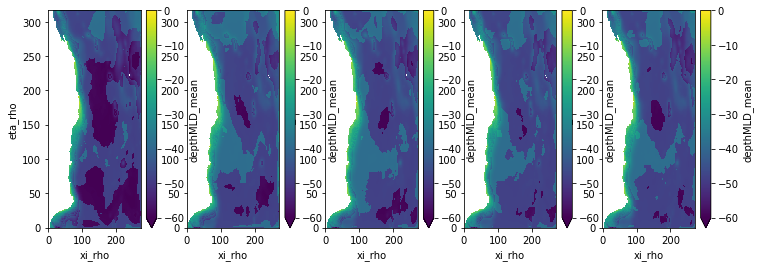

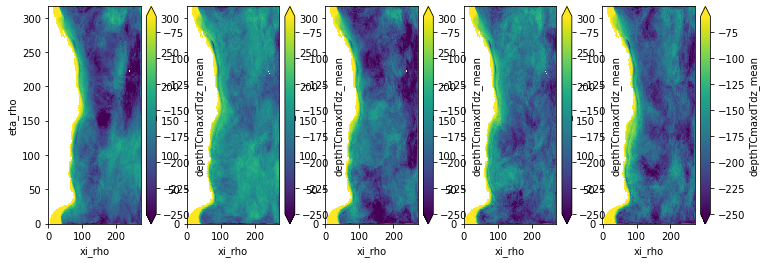

In [156]:
fig,ax=plt.subplots(ncols=5,figsize=(12,4))
truth.depthMLD_mean.plot(ax=ax[0],vmin=-60,vmax=-0)
SSHSST.depthMLD_mean.plot(ax=ax[1],vmin=-60,vmax=-0)
SSHSST_XBT_N.depthMLD_mean.plot(ax=ax[2],vmin=-60,vmax=-0)
SSHSST_XBT_S.depthMLD_mean.plot(ax=ax[3],vmin=-60,vmax=-0)
SSHSST_XBT.depthMLD_mean.plot(ax=ax[4],vmin=-60,vmax=-0)
plt.show()
fig,ax=plt.subplots(ncols=5,figsize=(12,4))
truth.depthTCmaxdTdz_mean.plot(ax=ax[0],vmin=-250,vmax=-60)
SSHSST.depthTCmaxdTdz_mean.plot(ax=ax[1],vmin=-250,vmax=-60)
SSHSST_XBT_N.depthTCmaxdTdz_mean.plot(ax=ax[2],vmin=-250,vmax=-60)
SSHSST_XBT_S.depthTCmaxdTdz_mean.plot(ax=ax[3],vmin=-250,vmax=-60)
SSHSST_XBT.depthTCmaxdTdz_mean.plot(ax=ax[4],vmin=-250,vmax=-60)

In [104]:
SSHSST["RMS_TCdTdzmax"] = (((SSHSST.depthTCmaxdTdz - truth.depthTCmaxdTdz)**2).mean(dim='ocean_time'))**0.5
SSHSST_XBT_N["RMS_TCdTdzmax"] = (((SSHSST_XBT_N.depthTCmaxdTdz - truth.depthTCmaxdTdz)**2).mean(dim='ocean_time'))**0.5
SSHSST_XBT_S["RMS_TCdTdzmax"] = (((SSHSST_XBT_S.depthTCmaxdTdz - truth.depthTCmaxdTdz)**2).mean(dim='ocean_time'))**0.5
SSHSST_XBT["RMS_TCdTdzmax"] = (((SSHSST_XBT.depthTCmaxdTdz - truth.depthTCmaxdTdz)**2).mean(dim='ocean_time'))**0.5

SSHSST["RMS_depthMLD"] = (((SSHSST.depthMLD - truth.depthMLD)**2).mean(dim='ocean_time'))**0.5
SSHSST_XBT_N["RMS_depthMLD"] = (((SSHSST_XBT_N.depthMLD - truth.depthMLD)**2).mean(dim='ocean_time'))**0.5
SSHSST_XBT_S["RMS_depthMLD"] = (((SSHSST_XBT_S.depthMLD - truth.depthMLD)**2).mean(dim='ocean_time'))**0.5
SSHSST_XBT["RMS_depthMLD"] = (((SSHSST_XBT.depthMLD - truth.depthMLD)**2).mean(dim='ocean_time'))**0.5

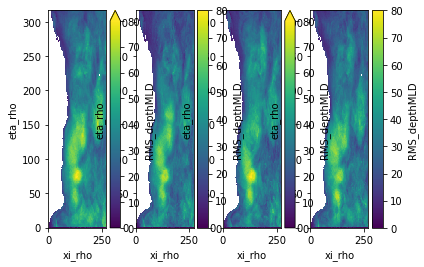

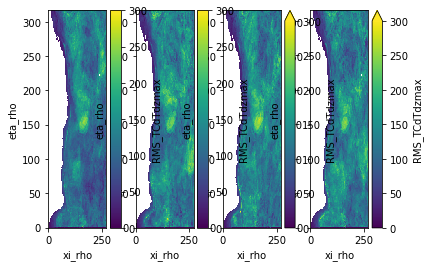

In [109]:
fig,ax=plt.subplots(ncols=4)
SSHSST.RMS_depthMLD.plot(ax=ax[0],vmin=0,vmax=80)
SSHSST_XBT_N.RMS_depthMLD.plot(ax=ax[1],vmin=0,vmax=80)
SSHSST_XBT_S.RMS_depthMLD.plot(ax=ax[2],vmin=0,vmax=80)
SSHSST_XBT.RMS_depthMLD.plot(ax=ax[3],vmin=0,vmax=80)
plt.show()
fig,ax=plt.subplots(ncols=4)
SSHSST.RMS_TCdTdzmax.plot(ax=ax[0],vmin=0,vmax=300)
SSHSST_XBT_N.RMS_TCdTdzmax.plot(ax=ax[1],vmin=0,vmax=300)
SSHSST_XBT_S.RMS_TCdTdzmax.plot(ax=ax[2],vmin=0,vmax=300)
SSHSST_XBT.RMS_TCdTdzmax.plot(ax=ax[3],vmin=0,vmax=300)

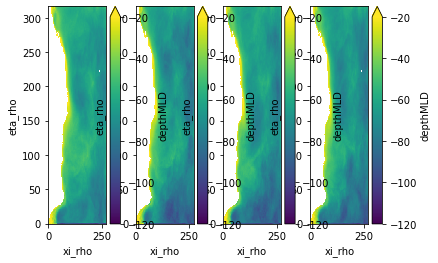

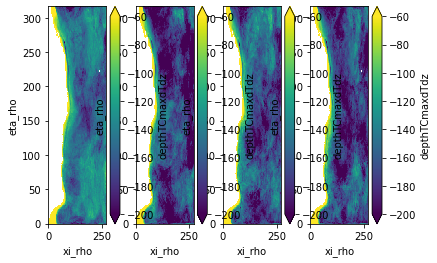

In [114]:
fig,ax=plt.subplots(ncols=4)
SSHSST.depthMLD.mean(dim='ocean_time').plot(ax=ax[0],vmin=-120,vmax=-20)
SSHSST_XBT_N.depthMLD.mean(dim='ocean_time').plot(ax=ax[1],vmin=-120,vmax=-20)
SSHSST_XBT_S.depthMLD.mean(dim='ocean_time').plot(ax=ax[2],vmin=-120,vmax=-20)
SSHSST_XBT.depthMLD.mean(dim='ocean_time').plot(ax=ax[3],vmin=-120,vmax=-20)
plt.show()
fig,ax=plt.subplots(ncols=4)
SSHSST.depthTCmaxdTdz.mean(dim='ocean_time').plot(ax=ax[0],vmin=-200,vmax=-60)
SSHSST_XBT_N.depthTCmaxdTdz.mean(dim='ocean_time').plot(ax=ax[1],vmin=-200,vmax=-60)
SSHSST_XBT_S.depthTCmaxdTdz.mean(dim='ocean_time').plot(ax=ax[2],vmin=-200,vmax=-60)
SSHSST_XBT.depthTCmaxdTdz.mean(dim='ocean_time').plot(ax=ax[3],vmin=-200,vmax=-60)

In [94]:
print(SSHSST.RMS_TCdTdzmax.isel(eta_rho=150,xi_rho=160).values)
print(truth.depthTCmaxdTdz.isel(eta_rho=150,xi_rho=160,ocean_time=-4).values)
print(SSHSST.depthTCmaxdTdz.isel(eta_rho=150,xi_rho=160,ocean_time=-4).values)


219.8559117465724
-857.7992427682092
-121.24258198530838


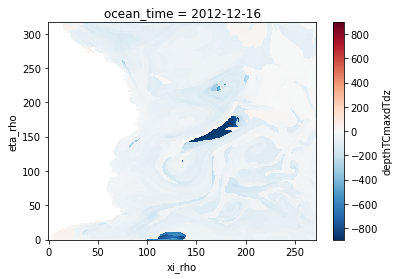

In [96]:
truth.depthTCmaxdTdz.isel(ocean_time=-4).plot()

(-2000.0, 0.0)

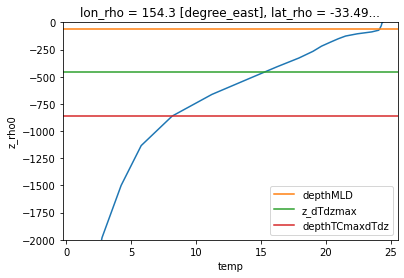

In [99]:
fig,ax=plt.subplots(1)
truth.temp.isel(eta_rho=150,xi_rho=160,ocean_time=7).plot(ax=ax,y='z_rho0')
ax.axhline(truth.depthMLD.isel(eta_rho=150,xi_rho=160,ocean_time=-4),label='depthMLD',color='C1')
ax.axhline(truth.z_dTdzmax.isel(eta_rho=150,xi_rho=160,ocean_time=-4),label='z_dTdzmax',color='C2')
ax.axhline(truth.depthTCmaxdTdz.isel(eta_rho=150,xi_rho=160,ocean_time=-4),label='depthTCmaxdTdz',color='C3')
ax.legend()
ax.set_ylim([-2000,0])

In [31]:
# Brief interlude to test the various area averaging functions
weights = truth_bu.dA
weights.name = "weights"
# xarray based area averaging
# test = truth.temp.isel(s_rho=-1).weighted(weights).mean(("eta_rho","xi_rho"))
# test.mean(("eta_rho","xi_rho"))

In [42]:
str(truth.depthMLD.mean(dim='ocean_time').weighted(weights).mean(("eta_rho","xi_rho")).round(decimals=1).values)

'-83.6'

<Figure size 432x288 with 0 Axes>

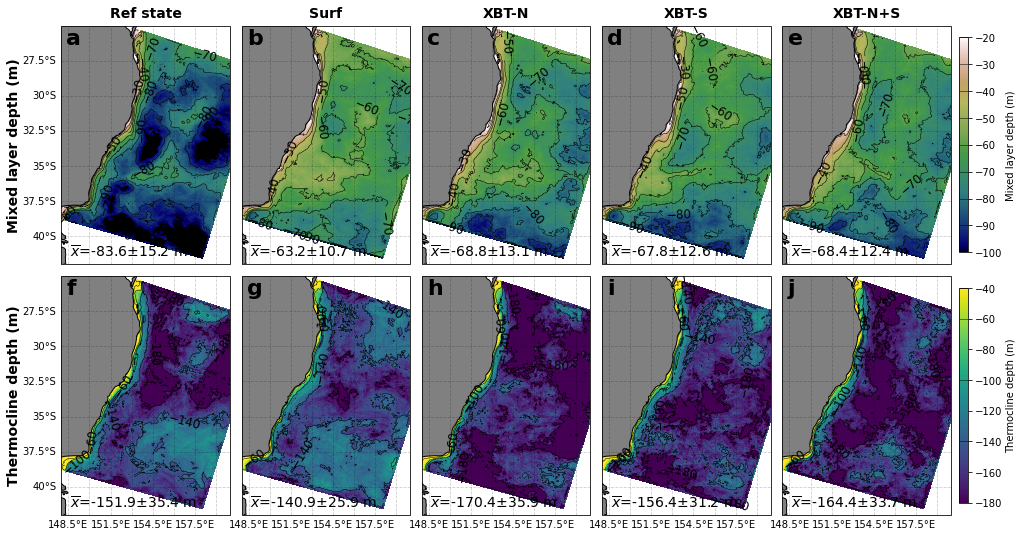

In [140]:


gs = gridspec.GridSpec(nrows=2,ncols=5,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[16,9])
ax = None

caxis_mld = [-100,-20]
ax = fig.add_subplot(gs[0,0],projection=ccrs.PlateCarree())
ax.add_feature(Coast, edgecolor='black',facecolor='gray')
truth.depthMLD.mean(dim='ocean_time').plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap='gist_earth',vmin=caxis_mld[0],vmax=caxis_mld[1])
co=ax.contour(truth.lon_rho,truth.lat_rho,truth.depthMLD.mean(dim='ocean_time'),colors='k',levels=np.arange(caxis_mld[0],caxis_mld[1]+10,10),linestyles='solid',linewidths=0.5)
ax.clabel(co, colors='k', fontsize=12)
ax.set_extent([148, 160, -42, -25])
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.bottom_labels = False
ax.text(0.5, 1.05, 'Ref state',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
ax.text(0.05, 0.05, ('$\overline{x}$='+str(truth.depthMLD.mean(dim='ocean_time').weighted(weights).mean(("eta_rho","xi_rho")).round(decimals=1).values)+'$\pm$'+str(truth.depthMLD.mean(dim='ocean_time').weighted(weights).std(("eta_rho","xi_rho")).round(decimals=1).values)+' m') ,fontsize=14, va='center', ha='left', transform=ax.transAxes)
ax.text(-.28, .5, 'Mixed layer depth (m)',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax.transAxes)
ax.text(0.03, 0.99, 'a', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')

ax = fig.add_subplot(gs[0,1],projection=ccrs.PlateCarree())
ax.add_feature(Coast, edgecolor='black',facecolor='gray')
SSHSST.depthMLD.mean(dim='ocean_time').plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap='gist_earth',vmin=caxis_mld[0],vmax=caxis_mld[1])
co=ax.contour(truth.lon_rho,truth.lat_rho,SSHSST.depthMLD.mean(dim='ocean_time'),colors='k',levels=np.arange(caxis_mld[0],caxis_mld[1]+10,10),linestyles='solid',linewidths=0.5)
ax.clabel(co, colors='k', fontsize=12)
ax.set_extent([148, 160, -42, -25])
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
gl.bottom_labels = False
ax.text(0.5, 1.05, 'Surf',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
ax.text(0.05, 0.05, ('$\overline{x}$='+str(SSHSST.depthMLD.mean(dim='ocean_time').weighted(weights).mean(("eta_rho","xi_rho")).round(decimals=1).values)+'$\pm$'+str(SSHSST.depthMLD.mean(dim='ocean_time').weighted(weights).std(("eta_rho","xi_rho")).round(decimals=1).values)+' m') ,fontsize=14, va='center', ha='left', transform=ax.transAxes)
ax.text(0.03, 0.99, 'b', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')

ax = fig.add_subplot(gs[0,2],projection=ccrs.PlateCarree())
ax.add_feature(Coast, edgecolor='black',facecolor='gray')
SSHSST_XBT_N.depthMLD.mean(dim='ocean_time').plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap='gist_earth',vmin=caxis_mld[0],vmax=caxis_mld[1])
co=ax.contour(truth.lon_rho,truth.lat_rho,SSHSST_XBT_N.depthMLD.mean(dim='ocean_time'),colors='k',levels=np.arange(caxis_mld[0],caxis_mld[1]+10,10),linestyles='solid',linewidths=0.5)
ax.clabel(co, colors='k', fontsize=12)
ax.set_extent([148, 160, -42, -25])
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
gl.bottom_labels = False
ax.text(0.5, 1.05, 'XBT-N',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
ax.text(0.05, 0.05, ('$\overline{x}$='+str(SSHSST_XBT_N.depthMLD.mean(dim='ocean_time').weighted(weights).mean(("eta_rho","xi_rho")).round(decimals=1).values)+'$\pm$'+str(SSHSST_XBT_N.depthMLD.mean(dim='ocean_time').weighted(weights).std(("eta_rho","xi_rho")).round(decimals=1).values)+' m') ,fontsize=14, va='center', ha='left', transform=ax.transAxes)
ax.text(0.03, 0.99, 'c', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')

ax = fig.add_subplot(gs[0,3],projection=ccrs.PlateCarree())
ax.add_feature(Coast, edgecolor='black',facecolor='gray')
SSHSST_XBT_S.depthMLD.mean(dim='ocean_time').plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap='gist_earth',vmin=caxis_mld[0],vmax=caxis_mld[1])
co=ax.contour(truth.lon_rho,truth.lat_rho,SSHSST_XBT_S.depthMLD.mean(dim='ocean_time'),colors='k',levels=np.arange(caxis_mld[0],caxis_mld[1]+10,10),linestyles='solid',linewidths=0.5)
ax.clabel(co, colors='k', fontsize=12)
ax.set_extent([148, 160, -42, -25])
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
gl.bottom_labels = False
ax.text(0.5, 1.05, 'XBT-S',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
ax.text(0.05, 0.05, ('$\overline{x}$='+str(SSHSST_XBT_S.depthMLD.mean(dim='ocean_time').weighted(weights).mean(("eta_rho","xi_rho")).round(decimals=1).values)+'$\pm$'+str(SSHSST_XBT_S.depthMLD.mean(dim='ocean_time').weighted(weights).std(("eta_rho","xi_rho")).round(decimals=1).values)+' m') ,fontsize=14, va='center', ha='left', transform=ax.transAxes)
ax.text(0.03, 0.99, 'd', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')

ax = fig.add_subplot(gs[0,4],projection=ccrs.PlateCarree())
ax.add_feature(Coast, edgecolor='black',facecolor='gray')
im=SSHSST_XBT.depthMLD.mean(dim='ocean_time').plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap='gist_earth',vmin=caxis_mld[0],vmax=caxis_mld[1])
co=ax.contour(truth.lon_rho,truth.lat_rho,SSHSST_XBT.depthMLD.mean(dim='ocean_time'),colors='k',levels=np.arange(caxis_mld[0],caxis_mld[1]+10,10),linestyles='solid',linewidths=0.5)
ax.clabel(co, colors='k', fontsize=12)
ax.set_extent([148, 160, -42, -25])
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
gl.bottom_labels = False
ax.text(0.5, 1.05, 'XBT-N+S',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
ax.text(0.05, 0.05, ('$\overline{x}$='+str(SSHSST_XBT.depthMLD.mean(dim='ocean_time').weighted(weights).mean(("eta_rho","xi_rho")).round(decimals=1).values)+'$\pm$'+str(SSHSST_XBT.depthMLD.mean(dim='ocean_time').weighted(weights).std(("eta_rho","xi_rho")).round(decimals=1).values)+' m') ,fontsize=14, va='center', ha='left', transform=ax.transAxes)
ax.text(0.03, 0.99, 'e', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')

cax = inset_axes(ax,
                width="5%",  # width = 10% of parent_bbox width
                height="90%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(1.05,.05, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax) 
cbar.ax.set_ylabel('Mixed layer depth (m)')
cbar.add_lines(co)

caxis_tc = [-180,-40]

ax = fig.add_subplot(gs[1,0],projection=ccrs.PlateCarree())
ax.add_feature(Coast, edgecolor='black',facecolor='gray')
truth.depthTCmaxdTdz.mean(dim='ocean_time').plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap='viridis',vmin=caxis_tc[0],vmax=caxis_tc[1])
co=ax.contour(truth.lon_rho,truth.lat_rho,truth.depthTCmaxdTdz.mean(dim='ocean_time'),colors='k',levels=np.arange(caxis_tc[0],caxis_tc[1]+40,40),linestyles='solid',linewidths=0.5)
ax.clabel(co, colors='k', fontsize=12)
ax.set_extent([148, 160, -42, -25])
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
# ax.text(0.5, 1.05, 'Ref state',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
ax.text(0.05, 0.05, ('$\overline{x}$='+str(truth.depthTCmaxdTdz.mean(dim='ocean_time').weighted(weights).mean(("eta_rho","xi_rho")).round(decimals=1).values)+'$\pm$'+str(truth.depthTCmaxdTdz.mean(dim='ocean_time').weighted(weights).std(("eta_rho","xi_rho")).round(decimals=1).values)+' m') ,fontsize=14, va='center', ha='left', transform=ax.transAxes)
ax.text(-.28, .5, 'Thermocline depth (m)',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax.transAxes)
ax.text(0.03, 0.99, 'f', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')

ax = fig.add_subplot(gs[1,1],projection=ccrs.PlateCarree())
ax.add_feature(Coast, edgecolor='black',facecolor='gray')
SSHSST.depthTCmaxdTdz.mean(dim='ocean_time').plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap='viridis',vmin=caxis_tc[0],vmax=caxis_tc[1])
co=ax.contour(truth.lon_rho,truth.lat_rho,SSHSST.depthTCmaxdTdz.mean(dim='ocean_time'),colors='k',levels=np.arange(caxis_tc[0],caxis_tc[1]+40,40),linestyles='solid',linewidths=0.5)
ax.clabel(co, colors='k', fontsize=12)
ax.set_extent([148, 160, -42, -25])
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
# ax.text(0.5, 1.05, 'Surf',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
ax.text(0.05, 0.05, ('$\overline{x}$='+str(SSHSST.depthTCmaxdTdz.mean(dim='ocean_time').weighted(weights).mean(("eta_rho","xi_rho")).round(decimals=1).values)+'$\pm$'+str(SSHSST.depthTCmaxdTdz.mean(dim='ocean_time').weighted(weights).std(("eta_rho","xi_rho")).round(decimals=1).values)+' m') ,fontsize=14, va='center', ha='left', transform=ax.transAxes)
ax.text(0.03, 0.99, 'g', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')

ax = fig.add_subplot(gs[1,2],projection=ccrs.PlateCarree())
ax.add_feature(Coast, edgecolor='black',facecolor='gray')
SSHSST_XBT_N.depthTCmaxdTdz.mean(dim='ocean_time').plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap='viridis',vmin=caxis_tc[0],vmax=caxis_tc[1])
co=ax.contour(truth.lon_rho,truth.lat_rho,SSHSST_XBT_N.depthTCmaxdTdz.mean(dim='ocean_time'),colors='k',levels=np.arange(caxis_tc[0],caxis_tc[1]+40,40),linestyles='solid',linewidths=0.5)
ax.clabel(co, colors='k', fontsize=12)
ax.set_extent([148, 160, -42, -25])
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
# ax.text(0.5, 1.05, 'XBT-N',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
ax.text(0.05, 0.05, ('$\overline{x}$='+str(SSHSST_XBT_N.depthTCmaxdTdz.mean(dim='ocean_time').weighted(weights).mean(("eta_rho","xi_rho")).round(decimals=1).values)+'$\pm$'+str(SSHSST_XBT_N.depthTCmaxdTdz.mean(dim='ocean_time').weighted(weights).std(("eta_rho","xi_rho")).round(decimals=1).values)+' m') ,fontsize=14, va='center', ha='left', transform=ax.transAxes)
ax.text(0.03, 0.99, 'h', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')

ax = fig.add_subplot(gs[1,3],projection=ccrs.PlateCarree())
ax.add_feature(Coast, edgecolor='black',facecolor='gray')
SSHSST_XBT_S.depthTCmaxdTdz.mean(dim='ocean_time').plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap='viridis',vmin=caxis_tc[0],vmax=caxis_tc[1])
co=ax.contour(truth.lon_rho,truth.lat_rho,SSHSST_XBT_S.depthTCmaxdTdz.mean(dim='ocean_time'),colors='k',levels=np.arange(caxis_tc[0],caxis_tc[1]+40,40),linestyles='solid',linewidths=0.5)
ax.clabel(co, colors='k', fontsize=12)
ax.set_extent([148, 160, -42, -25])
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
# ax.text(0.5, 1.05, 'XBT-S',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
ax.text(0.05, 0.05, ('$\overline{x}$='+str(SSHSST_XBT_S.depthTCmaxdTdz.mean(dim='ocean_time').weighted(weights).mean(("eta_rho","xi_rho")).round(decimals=1).values)+'$\pm$'+str(SSHSST_XBT_S.depthTCmaxdTdz.mean(dim='ocean_time').weighted(weights).std(("eta_rho","xi_rho")).round(decimals=1).values)+' m') ,fontsize=14, va='center', ha='left', transform=ax.transAxes)
ax.text(0.03, 0.99, 'i', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')

ax = fig.add_subplot(gs[1,4],projection=ccrs.PlateCarree())
ax.add_feature(Coast, edgecolor='black',facecolor='gray')
im=SSHSST_XBT.depthTCmaxdTdz.mean(dim='ocean_time').plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap='viridis',vmin=caxis_tc[0],vmax=caxis_tc[1])
co=ax.contour(truth.lon_rho,truth.lat_rho,SSHSST_XBT.depthTCmaxdTdz.mean(dim='ocean_time'),colors='k',levels=np.arange(caxis_tc[0],caxis_tc[1]+40,40),linestyles='solid',linewidths=0.5)
ax.clabel(co, colors='k', fontsize=12)
ax.set_extent([148, 160, -42, -25])
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
# ax.text(0.5, 1.05, 'XBT-N+S',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
ax.text(0.05, 0.05, ('$\overline{x}$='+str(SSHSST_XBT.depthTCmaxdTdz.mean(dim='ocean_time').weighted(weights).mean(("eta_rho","xi_rho")).round(decimals=1).values)+'$\pm$'+str(SSHSST_XBT.depthTCmaxdTdz.mean(dim='ocean_time').weighted(weights).std(("eta_rho","xi_rho")).round(decimals=1).values)+' m') ,fontsize=14, va='center', ha='left', transform=ax.transAxes)
ax.text(0.03, 0.99, 'j', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')

cax = inset_axes(ax,
                width="5%",  # width = 10% of parent_bbox width
                height="90%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(1.05,.05, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax) 
cbar.ax.set_ylabel('Thermocline depth (m)')
cbar.add_lines(co)


<Figure size 432x288 with 0 Axes>

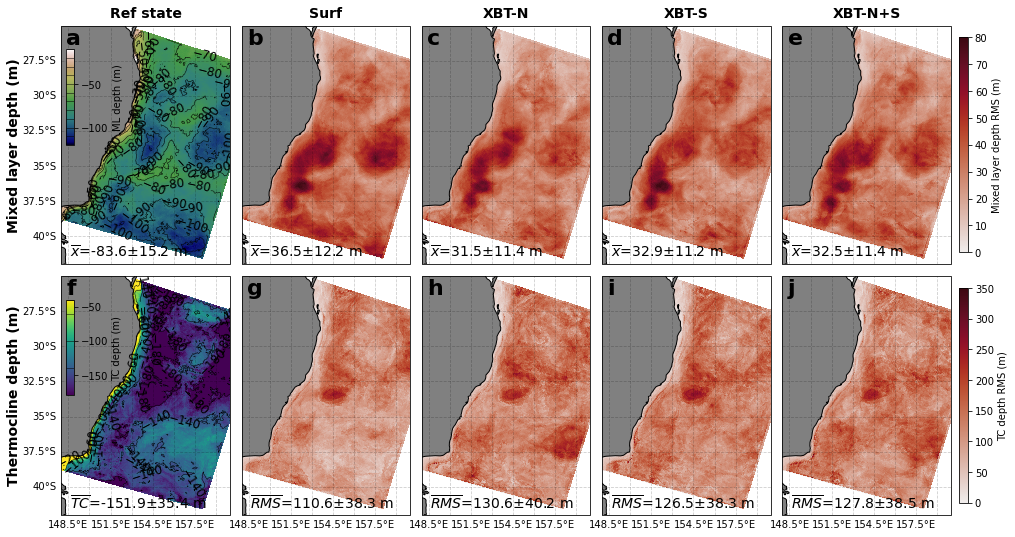

In [136]:


gs = gridspec.GridSpec(nrows=2,ncols=5,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[16,9])
ax = None

caxis_mld_truth = [-120,-10]
caxis_mld = [0,80]

ax = fig.add_subplot(gs[0,0],projection=ccrs.PlateCarree())
ax.add_feature(Coast, edgecolor='black',facecolor='gray')
im=truth.depthMLD.mean(dim='ocean_time').plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap='gist_earth',vmin=caxis_mld_truth[0],vmax=caxis_mld_truth[1])
co=ax.contour(truth.lon_rho,truth.lat_rho,truth.depthMLD.mean(dim='ocean_time'),colors='k',levels=np.arange(caxis_mld_truth[0],caxis_mld_truth[1]+10,10),linestyles='solid',linewidths=0.5)
ax.clabel(co, colors='k', fontsize=12)
ax.set_extent([148, 160, -42, -25])
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.bottom_labels = False
ax.text(0.5, 1.05, 'Ref state',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
ax.text(0.05, 0.05, ('$\overline{MLD}$='+str(truth.depthMLD.mean(dim='ocean_time').weighted(weights).mean(("eta_rho","xi_rho")).round(decimals=1).values)+'$\pm$'+str(truth.depthMLD.mean(dim='ocean_time').weighted(weights).std(("eta_rho","xi_rho")).round(decimals=1).values)+' m') ,fontsize=14, va='center', ha='left', transform=ax.transAxes)
ax.text(-.28, .5, 'Mixed layer depth (m)',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax.transAxes)
ax.text(0.03, 0.99, 'a', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
cax = inset_axes(ax,
                width="5%",  # width = 10% of parent_bbox width
                height="40%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(0.025,.5, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax) 
cbar.ax.set_ylabel('ML depth (m)')
cbar.add_lines(co)

ax = fig.add_subplot(gs[0,1],projection=ccrs.PlateCarree())
ax.add_feature(Coast, edgecolor='black',facecolor='gray')
SSHSST.RMS_depthMLD.plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap='cmo.amp',vmin=caxis_mld[0],vmax=caxis_mld[1])
# co=ax.contour(truth.lon_rho,truth.lat_rho,SSHSST.RMS_depthMLD,colors='k',levels=np.arange(caxis_mld[0],caxis_mld[1]+10,10),linestyles='solid',linewidths=0.5)
ax.clabel(co, colors='k', fontsize=12)
ax.set_extent([148, 160, -42, -25])
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
gl.bottom_labels = False
ax.text(0.5, 1.05, 'Surf',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
ax.text(0.05, 0.05, ('$\overline{RMS}$='+str(SSHSST.RMS_depthMLD.weighted(weights).mean(("eta_rho","xi_rho")).round(decimals=1).values)+'$\pm$'+str(SSHSST.RMS_depthMLD.weighted(weights).std(("eta_rho","xi_rho")).round(decimals=1).values)+' m') ,fontsize=14, va='center', ha='left', transform=ax.transAxes)
ax.text(0.03, 0.99, 'b', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')

ax = fig.add_subplot(gs[0,2],projection=ccrs.PlateCarree())
ax.add_feature(Coast, edgecolor='black',facecolor='gray')
SSHSST_XBT_N.RMS_depthMLD.plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap='cmo.amp',vmin=caxis_mld[0],vmax=caxis_mld[1])
# co=ax.contour(truth.lon_rho,truth.lat_rho,SSHSST_XBT_N.RMS_depthMLD,colors='k',levels=np.arange(caxis_mld[0],caxis_mld[1]+10,10),linestyles='solid',linewidths=0.5)
ax.clabel(co, colors='k', fontsize=12)
ax.set_extent([148, 160, -42, -25])
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
gl.bottom_labels = False
ax.text(0.5, 1.05, 'XBT-N',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
ax.text(0.05, 0.05, ('$\overline{RMS}$='+str(SSHSST_XBT_N.RMS_depthMLD.weighted(weights).mean(("eta_rho","xi_rho")).round(decimals=1).values)+'$\pm$'+str(SSHSST_XBT_N.RMS_depthMLD.weighted(weights).std(("eta_rho","xi_rho")).round(decimals=1).values)+' m') ,fontsize=14, va='center', ha='left', transform=ax.transAxes)
ax.text(0.03, 0.99, 'c', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')

ax = fig.add_subplot(gs[0,3],projection=ccrs.PlateCarree())
ax.add_feature(Coast, edgecolor='black',facecolor='gray')
SSHSST_XBT_S.RMS_depthMLD.plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap='cmo.amp',vmin=caxis_mld[0],vmax=caxis_mld[1])
# co=ax.contour(truth.lon_rho,truth.lat_rho,SSHSST_XBT_S.RMS_depthMLD,colors='k',levels=np.arange(caxis_mld[0],caxis_mld[1]+10,10),linestyles='solid',linewidths=0.5)
ax.clabel(co, colors='k', fontsize=12)
ax.set_extent([148, 160, -42, -25])
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
gl.bottom_labels = False
ax.text(0.5, 1.05, 'XBT-S',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
ax.text(0.05, 0.05, ('$\overline{RMS}$='+str(SSHSST_XBT_S.RMS_depthMLD.weighted(weights).mean(("eta_rho","xi_rho")).round(decimals=1).values)+'$\pm$'+str(SSHSST_XBT_S.RMS_depthMLD.weighted(weights).std(("eta_rho","xi_rho")).round(decimals=1).values)+' m') ,fontsize=14, va='center', ha='left', transform=ax.transAxes)
ax.text(0.03, 0.99, 'd', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')

ax = fig.add_subplot(gs[0,4],projection=ccrs.PlateCarree())
ax.add_feature(Coast, edgecolor='black',facecolor='gray')
im=SSHSST_XBT.RMS_depthMLD.plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap='cmo.amp',vmin=caxis_mld[0],vmax=caxis_mld[1])
# co=ax.contour(truth.lon_rho,truth.lat_rho,SSHSST_XBT.RMS_depthMLD,colors='k',levels=np.arange(caxis_mld[0],caxis_mld[1]+10,10),linestyles='solid',linewidths=0.5)
ax.clabel(co, colors='k', fontsize=12)
ax.set_extent([148, 160, -42, -25])
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
gl.bottom_labels = False
ax.text(0.5, 1.05, 'XBT-N+S',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
ax.text(0.05, 0.05, ('$\overline{RMS}$='+str(SSHSST_XBT.RMS_depthMLD.weighted(weights).mean(("eta_rho","xi_rho")).round(decimals=1).values)+'$\pm$'+str(SSHSST_XBT.RMS_depthMLD.weighted(weights).std(("eta_rho","xi_rho")).round(decimals=1).values)+' m') ,fontsize=14, va='center', ha='left', transform=ax.transAxes)
ax.text(0.03, 0.99, 'e', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')

cax = inset_axes(ax,
                width="5%",  # width = 10% of parent_bbox width
                height="90%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(1.05,.05, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax) 
cbar.ax.set_ylabel('Mixed layer depth RMS (m)')
cbar.add_lines(co)

caxis_tc_truth = [-180,-40] #for rms
caxis_tc = [0,350] #for rms

ax = fig.add_subplot(gs[1,0],projection=ccrs.PlateCarree())
ax.add_feature(Coast, edgecolor='black',facecolor='gray')
im=truth.depthTCmaxdTdz.mean(dim='ocean_time').plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap='viridis',vmin=caxis_tc_truth[0],vmax=caxis_tc_truth[1])
co=ax.contour(truth.lon_rho,truth.lat_rho,truth.depthTCmaxdTdz.mean(dim='ocean_time'),colors='k',levels=np.arange(caxis_tc_truth[0],caxis_tc_truth[1]+40,40),linestyles='solid',linewidths=0.5)
ax.clabel(co, colors='k', fontsize=12)
ax.set_extent([148, 160, -42, -25])
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
# ax.text(0.5, 1.05, 'Ref state',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
ax.text(0.05, 0.05, ('$\overline{TC}$='+str(truth.depthTCmaxdTdz.mean(dim='ocean_time').weighted(weights).mean(("eta_rho","xi_rho")).round(decimals=1).values)+'$\pm$'+str(truth.depthTCmaxdTdz.mean(dim='ocean_time').weighted(weights).std(("eta_rho","xi_rho")).round(decimals=1).values)+' m') ,fontsize=14, va='center', ha='left', transform=ax.transAxes)
ax.text(-.28, .5, 'Thermocline depth (m)',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax.transAxes)
ax.text(0.03, 0.99, 'f', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
cax = inset_axes(ax,
                width="5%",  # width = 10% of parent_bbox width
                height="40%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(0.025,.5, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax) 
cbar.ax.set_ylabel('TC depth (m)')
cbar.add_lines(co)

ax = fig.add_subplot(gs[1,1],projection=ccrs.PlateCarree())
ax.add_feature(Coast, edgecolor='black',facecolor='gray')
SSHSST.RMS_TCdTdzmax.plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap='cmo.amp',vmin=caxis_tc[0],vmax=caxis_tc[1])
# co=ax.contour(truth.lon_rho,truth.lat_rho,SSHSST.RMS_TCdTdzmax,colors='k',levels=np.arange(caxis_tc[0],caxis_tc[1]+50,50),linestyles='solid',linewidths=0.5)
ax.clabel(co, colors='k', fontsize=12)
ax.set_extent([148, 160, -42, -25])
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
# ax.text(0.5, 1.05, 'Surf',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
ax.text(0.05, 0.05, ('$\overline{RMS}$='+str(SSHSST.RMS_TCdTdzmax.weighted(weights).mean(("eta_rho","xi_rho")).round(decimals=1).values)+'$\pm$'+str(SSHSST.RMS_TCdTdzmax.weighted(weights).std(("eta_rho","xi_rho")).round(decimals=1).values)+' m') ,fontsize=14, va='center', ha='left', transform=ax.transAxes)
ax.text(0.03, 0.99, 'g', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')

ax = fig.add_subplot(gs[1,2],projection=ccrs.PlateCarree())
ax.add_feature(Coast, edgecolor='black',facecolor='gray')
SSHSST_XBT_N.RMS_TCdTdzmax.plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap='cmo.amp',vmin=caxis_tc[0],vmax=caxis_tc[1])
# co=ax.contour(truth.lon_rho,truth.lat_rho,SSHSST_XBT_N.RMS_TCdTdzmax,colors='k',levels=np.arange(caxis_tc[0],caxis_tc[1]+50,50),linestyles='solid',linewidths=0.5)
ax.clabel(co, colors='k', fontsize=12)
ax.set_extent([148, 160, -42, -25])
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
# ax.text(0.5, 1.05, 'XBT-N',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
ax.text(0.05, 0.05, ('$\overline{RMS}$='+str(SSHSST_XBT_N.RMS_TCdTdzmax.weighted(weights).mean(("eta_rho","xi_rho")).round(decimals=1).values)+'$\pm$'+str(SSHSST_XBT_N.RMS_TCdTdzmax.weighted(weights).std(("eta_rho","xi_rho")).round(decimals=1).values)+' m') ,fontsize=14, va='center', ha='left', transform=ax.transAxes)
ax.text(0.03, 0.99, 'h', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')

ax = fig.add_subplot(gs[1,3],projection=ccrs.PlateCarree())
ax.add_feature(Coast, edgecolor='black',facecolor='gray')
SSHSST_XBT_S.RMS_TCdTdzmax.plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap='cmo.amp',vmin=caxis_tc[0],vmax=caxis_tc[1])
# co=ax.contour(truth.lon_rho,truth.lat_rho,SSHSST_XBT_S.RMS_TCdTdzmax,colors='k',levels=np.arange(caxis_tc[0],caxis_tc[1]+50,50),linestyles='solid',linewidths=0.5)
ax.clabel(co, colors='k', fontsize=12)
ax.set_extent([148, 160, -42, -25])
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
# ax.text(0.5, 1.05, 'XBT-S',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
ax.text(0.05, 0.05, ('$\overline{RMS}$='+str(SSHSST_XBT_S.RMS_TCdTdzmax.weighted(weights).mean(("eta_rho","xi_rho")).round(decimals=1).values)+'$\pm$'+str(SSHSST_XBT_S.RMS_TCdTdzmax.weighted(weights).std(("eta_rho","xi_rho")).round(decimals=1).values)+' m') ,fontsize=14, va='center', ha='left', transform=ax.transAxes)
ax.text(0.03, 0.99, 'i', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')

ax = fig.add_subplot(gs[1,4],projection=ccrs.PlateCarree())
ax.add_feature(Coast, edgecolor='black',facecolor='gray')
im=SSHSST_XBT.RMS_TCdTdzmax.plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap='cmo.amp',vmin=caxis_tc[0],vmax=caxis_tc[1])
# co=ax.contour(truth.lon_rho,truth.lat_rho,SSHSST_XBT.RMS_TCdTdzmax,colors='k',levels=np.arange(caxis_tc[0],caxis_tc[1]+50,50),linestyles='solid',linewidths=0.25)
ax.clabel(co, colors='k', fontsize=12)
ax.set_extent([148, 160, -42, -25])
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
# ax.text(0.5, 1.05, 'XBT-N+S',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
ax.text(0.05, 0.05, ('$\overline{RMS}$='+str(SSHSST_XBT.RMS_TCdTdzmax.weighted(weights).mean(("eta_rho","xi_rho")).round(decimals=1).values)+'$\pm$'+str(SSHSST_XBT.RMS_TCdTdzmax.weighted(weights).std(("eta_rho","xi_rho")).round(decimals=1).values)+' m') ,fontsize=14, va='center', ha='left', transform=ax.transAxes)
ax.text(0.03, 0.99, 'j', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')

cax = inset_axes(ax,
                width="5%",  # width = 10% of parent_bbox width
                height="90%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(1.05,.05, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax) 
cbar.ax.set_ylabel('TC depth RMS (m)')
cbar.add_lines(co)


<Figure size 432x288 with 0 Axes>

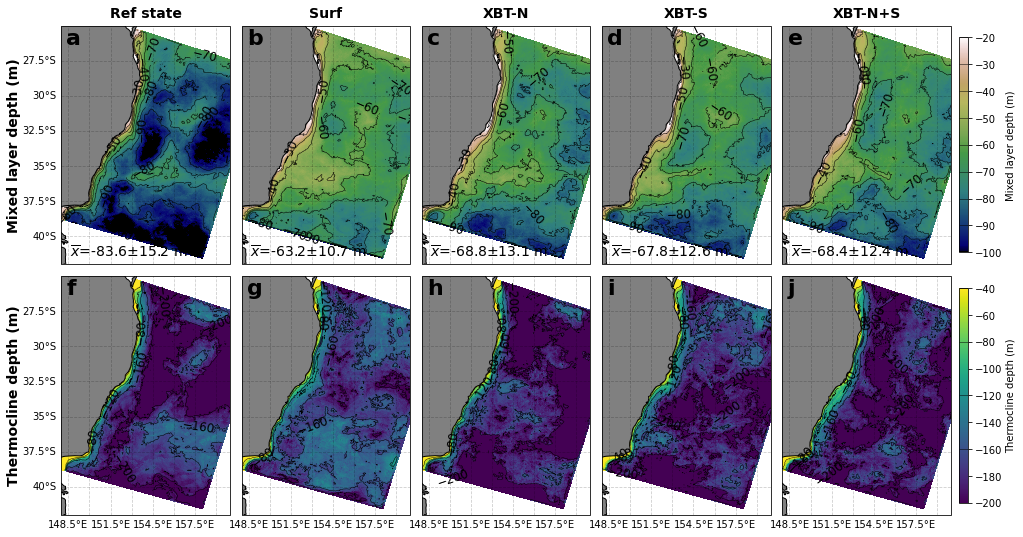

In [158]:


gs = gridspec.GridSpec(nrows=2,ncols=5,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[16,9])
ax = None

caxis_mld = [-100,-20]
ax = fig.add_subplot(gs[0,0],projection=ccrs.PlateCarree())
ax.add_feature(Coast, edgecolor='black',facecolor='gray')
truth.depthMLD.mean(dim='ocean_time').plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap='gist_earth',vmin=caxis_mld[0],vmax=caxis_mld[1])
co=ax.contour(truth.lon_rho,truth.lat_rho,truth.depthMLD.mean(dim='ocean_time'),colors='k',levels=np.arange(caxis_mld[0],caxis_mld[1]+10,10),linestyles='solid',linewidths=0.5)
ax.clabel(co, colors='k', fontsize=12)
ax.set_extent([148, 160, -42, -25])
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.bottom_labels = False
ax.text(0.5, 1.05, 'Ref state',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
ax.text(0.05, 0.05, ('$\overline{x}$='+str(truth.depthMLD.mean(dim='ocean_time').weighted(weights).mean(("eta_rho","xi_rho")).round(decimals=1).values)+'$\pm$'+str(truth.depthMLD.mean(dim='ocean_time').weighted(weights).std(("eta_rho","xi_rho")).round(decimals=1).values)+' m') ,fontsize=14, va='center', ha='left', transform=ax.transAxes)
ax.text(-.28, .5, 'Mixed layer depth (m)',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax.transAxes)
ax.text(0.03, 0.99, 'a', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')

ax = fig.add_subplot(gs[0,1],projection=ccrs.PlateCarree())
ax.add_feature(Coast, edgecolor='black',facecolor='gray')
SSHSST.depthMLD.mean(dim='ocean_time').plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap='gist_earth',vmin=caxis_mld[0],vmax=caxis_mld[1])
co=ax.contour(truth.lon_rho,truth.lat_rho,SSHSST.depthMLD.mean(dim='ocean_time'),colors='k',levels=np.arange(caxis_mld[0],caxis_mld[1]+10,10),linestyles='solid',linewidths=0.5)
ax.clabel(co, colors='k', fontsize=12)
ax.set_extent([148, 160, -42, -25])
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
gl.bottom_labels = False
ax.text(0.5, 1.05, 'Surf',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
ax.text(0.05, 0.05, ('$\overline{x}$='+str(SSHSST.depthMLD.mean(dim='ocean_time').weighted(weights).mean(("eta_rho","xi_rho")).round(decimals=1).values)+'$\pm$'+str(SSHSST.depthMLD.mean(dim='ocean_time').weighted(weights).std(("eta_rho","xi_rho")).round(decimals=1).values)+' m') ,fontsize=14, va='center', ha='left', transform=ax.transAxes)
ax.text(0.03, 0.99, 'b', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')

ax = fig.add_subplot(gs[0,2],projection=ccrs.PlateCarree())
ax.add_feature(Coast, edgecolor='black',facecolor='gray')
SSHSST_XBT_N.depthMLD.mean(dim='ocean_time').plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap='gist_earth',vmin=caxis_mld[0],vmax=caxis_mld[1])
co=ax.contour(truth.lon_rho,truth.lat_rho,SSHSST_XBT_N.depthMLD.mean(dim='ocean_time'),colors='k',levels=np.arange(caxis_mld[0],caxis_mld[1]+10,10),linestyles='solid',linewidths=0.5)
ax.clabel(co, colors='k', fontsize=12)
ax.set_extent([148, 160, -42, -25])
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
gl.bottom_labels = False
ax.text(0.5, 1.05, 'XBT-N',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
ax.text(0.05, 0.05, ('$\overline{x}$='+str(SSHSST_XBT_N.depthMLD.mean(dim='ocean_time').weighted(weights).mean(("eta_rho","xi_rho")).round(decimals=1).values)+'$\pm$'+str(SSHSST_XBT_N.depthMLD.mean(dim='ocean_time').weighted(weights).std(("eta_rho","xi_rho")).round(decimals=1).values)+' m') ,fontsize=14, va='center', ha='left', transform=ax.transAxes)
ax.text(0.03, 0.99, 'c', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')

ax = fig.add_subplot(gs[0,3],projection=ccrs.PlateCarree())
ax.add_feature(Coast, edgecolor='black',facecolor='gray')
SSHSST_XBT_S.depthMLD.mean(dim='ocean_time').plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap='gist_earth',vmin=caxis_mld[0],vmax=caxis_mld[1])
co=ax.contour(truth.lon_rho,truth.lat_rho,SSHSST_XBT_S.depthMLD.mean(dim='ocean_time'),colors='k',levels=np.arange(caxis_mld[0],caxis_mld[1]+10,10),linestyles='solid',linewidths=0.5)
ax.clabel(co, colors='k', fontsize=12)
ax.set_extent([148, 160, -42, -25])
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
gl.bottom_labels = False
ax.text(0.5, 1.05, 'XBT-S',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
ax.text(0.05, 0.05, ('$\overline{x}$='+str(SSHSST_XBT_S.depthMLD.mean(dim='ocean_time').weighted(weights).mean(("eta_rho","xi_rho")).round(decimals=1).values)+'$\pm$'+str(SSHSST_XBT_S.depthMLD.mean(dim='ocean_time').weighted(weights).std(("eta_rho","xi_rho")).round(decimals=1).values)+' m') ,fontsize=14, va='center', ha='left', transform=ax.transAxes)
ax.text(0.03, 0.99, 'd', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')

ax = fig.add_subplot(gs[0,4],projection=ccrs.PlateCarree())
ax.add_feature(Coast, edgecolor='black',facecolor='gray')
im=SSHSST_XBT.depthMLD.mean(dim='ocean_time').plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap='gist_earth',vmin=caxis_mld[0],vmax=caxis_mld[1])
co=ax.contour(truth.lon_rho,truth.lat_rho,SSHSST_XBT.depthMLD.mean(dim='ocean_time'),colors='k',levels=np.arange(caxis_mld[0],caxis_mld[1]+10,10),linestyles='solid',linewidths=0.5)
ax.clabel(co, colors='k', fontsize=12)
ax.set_extent([148, 160, -42, -25])
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
gl.bottom_labels = False
ax.text(0.5, 1.05, 'XBT-N+S',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
ax.text(0.05, 0.05, ('$\overline{x}$='+str(SSHSST_XBT.depthMLD.mean(dim='ocean_time').weighted(weights).mean(("eta_rho","xi_rho")).round(decimals=1).values)+'$\pm$'+str(SSHSST_XBT.depthMLD.mean(dim='ocean_time').weighted(weights).std(("eta_rho","xi_rho")).round(decimals=1).values)+' m') ,fontsize=14, va='center', ha='left', transform=ax.transAxes)
ax.text(0.03, 0.99, 'e', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')

cax = inset_axes(ax,
                width="5%",  # width = 10% of parent_bbox width
                height="90%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(1.05,.05, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax) 
cbar.ax.set_ylabel('Mixed layer depth (m)')
cbar.add_lines(co)

caxis_tc = [-200,-40]

ax = fig.add_subplot(gs[1,0],projection=ccrs.PlateCarree())
ax.add_feature(Coast, edgecolor='black',facecolor='gray')
truth.depthTCmaxdTdz_mean.plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap='viridis',vmin=caxis_tc[0],vmax=caxis_tc[1])
co=ax.contour(truth.lon_rho,truth.lat_rho,truth.depthTCmaxdTdz_mean,colors='k',levels=np.arange(caxis_tc[0],caxis_tc[1]+40,40),linestyles='solid',linewidths=0.5)
ax.clabel(co, colors='k', fontsize=12)
ax.set_extent([148, 160, -42, -25])
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
# ax.text(0.5, 1.05, 'Ref state',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
# ax.text(0.05, 0.05, ('$\overline{x}$='+str(truth.depthTCmaxdTdz.mean(dim='ocean_time').weighted(weights).mean(("eta_rho","xi_rho")).round(decimals=1).values)+'$\pm$'+str(truth.depthTCmaxdTdz.mean(dim='ocean_time').weighted(weights).std(("eta_rho","xi_rho")).round(decimals=1).values)+' m') ,fontsize=14, va='center', ha='left', transform=ax.transAxes)
ax.text(-.28, .5, 'Thermocline depth (m)',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax.transAxes)
ax.text(0.03, 0.99, 'f', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')

ax = fig.add_subplot(gs[1,1],projection=ccrs.PlateCarree())
ax.add_feature(Coast, edgecolor='black',facecolor='gray')
SSHSST.depthTCmaxdTdz_mean.plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap='viridis',vmin=caxis_tc[0],vmax=caxis_tc[1])
co=ax.contour(truth.lon_rho,truth.lat_rho,SSHSST.depthTCmaxdTdz_mean,colors='k',levels=np.arange(caxis_tc[0],caxis_tc[1]+40,40),linestyles='solid',linewidths=0.5)
ax.clabel(co, colors='k', fontsize=12)
ax.set_extent([148, 160, -42, -25])
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
# ax.text(0.5, 1.05, 'Surf',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
# ax.text(0.05, 0.05, ('$\overline{x}$='+str(SSHSST.depthTCmaxdTdz.mean(dim='ocean_time').weighted(weights).mean(("eta_rho","xi_rho")).round(decimals=1).values)+'$\pm$'+str(SSHSST.depthTCmaxdTdz.mean(dim='ocean_time').weighted(weights).std(("eta_rho","xi_rho")).round(decimals=1).values)+' m') ,fontsize=14, va='center', ha='left', transform=ax.transAxes)
ax.text(0.03, 0.99, 'g', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')

ax = fig.add_subplot(gs[1,2],projection=ccrs.PlateCarree())
ax.add_feature(Coast, edgecolor='black',facecolor='gray')
SSHSST_XBT_N.depthTCmaxdTdz_mean.plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap='viridis',vmin=caxis_tc[0],vmax=caxis_tc[1])
co=ax.contour(truth.lon_rho,truth.lat_rho,SSHSST_XBT_N.depthTCmaxdTdz_mean,colors='k',levels=np.arange(caxis_tc[0],caxis_tc[1]+40,40),linestyles='solid',linewidths=0.5)
ax.clabel(co, colors='k', fontsize=12)
ax.set_extent([148, 160, -42, -25])
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
# ax.text(0.5, 1.05, 'XBT-N',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
# ax.text(0.05, 0.05, ('$\overline{x}$='+str(SSHSST_XBT_N.depthTCmaxdTdz.mean(dim='ocean_time').weighted(weights).mean(("eta_rho","xi_rho")).round(decimals=1).values)+'$\pm$'+str(SSHSST_XBT_N.depthTCmaxdTdz.mean(dim='ocean_time').weighted(weights).std(("eta_rho","xi_rho")).round(decimals=1).values)+' m') ,fontsize=14, va='center', ha='left', transform=ax.transAxes)
ax.text(0.03, 0.99, 'h', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')

ax = fig.add_subplot(gs[1,3],projection=ccrs.PlateCarree())
ax.add_feature(Coast, edgecolor='black',facecolor='gray')
SSHSST_XBT_S.depthTCmaxdTdz_mean.plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap='viridis',vmin=caxis_tc[0],vmax=caxis_tc[1])
co=ax.contour(truth.lon_rho,truth.lat_rho,SSHSST_XBT_S.depthTCmaxdTdz_mean,colors='k',levels=np.arange(caxis_tc[0],caxis_tc[1]+40,40),linestyles='solid',linewidths=0.5)
ax.clabel(co, colors='k', fontsize=12)
ax.set_extent([148, 160, -42, -25])
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
# ax.text(0.5, 1.05, 'XBT-S',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
# ax.text(0.05, 0.05, ('$\overline{x}$='+str(SSHSST_XBT_S.depthTCmaxdTdz.mean(dim='ocean_time').weighted(weights).mean(("eta_rho","xi_rho")).round(decimals=1).values)+'$\pm$'+str(SSHSST_XBT_S.depthTCmaxdTdz.mean(dim='ocean_time').weighted(weights).std(("eta_rho","xi_rho")).round(decimals=1).values)+' m') ,fontsize=14, va='center', ha='left', transform=ax.transAxes)
ax.text(0.03, 0.99, 'i', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')

ax = fig.add_subplot(gs[1,4],projection=ccrs.PlateCarree())
ax.add_feature(Coast, edgecolor='black',facecolor='gray')
im=SSHSST_XBT.depthTCmaxdTdz_mean.plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap='viridis',vmin=caxis_tc[0],vmax=caxis_tc[1])
co=ax.contour(truth.lon_rho,truth.lat_rho,SSHSST_XBT.depthTCmaxdTdz_mean,colors='k',levels=np.arange(caxis_tc[0],caxis_tc[1]+40,40),linestyles='solid',linewidths=0.5)
ax.clabel(co, colors='k', fontsize=12)
ax.set_extent([148, 160, -42, -25])
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
# ax.text(0.5, 1.05, 'XBT-N+S',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
# ax.text(0.05, 0.05, ('$\overline{x}$='+str(SSHSST_XBT.depthTCmaxdTdz.mean(dim='ocean_time').weighted(weights).mean(("eta_rho","xi_rho")).round(decimals=1).values)+'$\pm$'+str(SSHSST_XBT.depthTCmaxdTdz.mean(dim='ocean_time').weighted(weights).std(("eta_rho","xi_rho")).round(decimals=1).values)+' m') ,fontsize=14, va='center', ha='left', transform=ax.transAxes)
ax.text(0.03, 0.99, 'j', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')

cax = inset_axes(ax,
                width="5%",  # width = 10% of parent_bbox width
                height="90%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(1.05,.05, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax) 
cbar.ax.set_ylabel('Thermocline depth (m)')
cbar.add_lines(co)
